# <span style="color:red"> Main Modelling - Logistic Regression - Gridsearch </span>

* read in pickle v02
* keep 3 translators
* try different feature sets and save model each time
* compare results at the end
* all features available ie normalised counts and pos counts with some drops plus unique words, adj, adv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

book_chunk_no number                       title  \
0              0      1  Wednesday Afternoon Picnic   

                                                text  \
0  IT WAS A  short one-paragraph item in the morn...   

                                       fstop_indices  \
0  [57, 97, 115, 196, 318, 385, 420, 445, 504, 65...   

                                       split_indices  \
0  [967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...   

                                              chunks       translator  \
0  IT WAS A short one-paragraph item in the morni...  Alfred Birnbaum   

           book_title                                             parsed  \
0  A Wild Sheep Chase  (IT, WAS, A, short, one, -, paragraph, item, i...   

   n_sents  n_words  n_chars  n_syllables  n_unique_words  n_long_words  \
0       15      174      742          240             116            33   

   n_monosyllable_words  n_polysyllable_words  trans_code  chunk_length  \
0                   128                    17           0           944   

   n_sents_norm  n_words_norm  n_chars_norm  n_syllables_norm  \
0     15.889831    184.322034    786.016949        254.237288   

   n_unique_words_norm  n_long_words_norm  n_monosyllable_words_norm  \
0           122.881356          34.957627                  135.59322   

   n_polysyllable_words_norm  vader_compound  vader_neg  vader_neu  vader_pos  \
0                  18.008475         -0.4798      0.075      0.862      0.064   

   pron_count  verb_count  det_count  adj_count  num_count  punct_count  \
0        18.0        20.0       31.0        9.0        2.0         33.0   

   noun_count  adp_count  cconj_count  sconj_count  adv_count  aux_count  \
0        51.0       19.0          6.0          3.0        5.0        5.0   

   part_count  propn_count  space_count  intj_count  sym_count  x_count  ...  \
0         3.0          2.0          0.0         0.0        0.0      0.0  ...   

   very_adv  now_adv  when_adv  never_adv  even_adv  why_adv  too_adv  \
0         0        0         0          0         1        0        0   

   still_adv  so_adv  as_adv  how_adv  maybe_adv  here_adv  only_adv  \
0          0       0       0        0          0         0         0   

   more_adv  back_adv  where_adv  then_adv  again_adv  there_adv  just_adv  \
0         0         0          1         0          0          0         0   

   next_adj  few_adj  sure_adj  able_adj  whole_adj  much_adj  first_adj  \
0         0        0         0         0          1         0          0   

   own_adj  deep_adj  little_adj  same_adj  last_adj  strange_adj  small_adj  \
0        0         0           0         0         0            0          0   

  bad_adj long_adj good_adj big_adj  new_adj  different_adj  hard_adj  \
0       0        0        0       0        0              0         0   

   old_adj  young_adj  only_adj  more_adj  other_adj  right_adj  real_adj  \
0        1          0         0         0          0          0         0   

   vlong_words_count  
0                  0  

[1 rows x 142 columns]

In [4]:
df.shape

(5212, 142)

In [5]:
# df.book_title.unique()

In [6]:
# df = df[df['book_title'] != 'A Wild Sheep Chase']

In [7]:
# df.book_title.unique()

In [8]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'different_adj', 'hard_adj', 'old_adj', 'young_adj', 'only_adj',
       'more_adj', 'other_adj', 'right_adj', 'real_adj', 'vlong_words_count'],
      dtype='object', length=142)

### Check the baseline

In [9]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

### Set initial Predictor Variables
* Choose normalised count variables from textacy, ntlk dropping some suspicious ones
* not using vader sentiment scores

In [10]:
df.columns[20:60]

Index(['n_sents_norm', 'n_words_norm', 'n_chars_norm', 'n_syllables_norm',
       'n_unique_words_norm', 'n_long_words_norm', 'n_monosyllable_words_norm',
       'n_polysyllable_words_norm', 'vader_compound', 'vader_neg', 'vader_neu',
       'vader_pos', 'pron_count', 'verb_count', 'det_count', 'adj_count',
       'num_count', 'punct_count', 'noun_count', 'adp_count', 'cconj_count',
       'sconj_count', 'adv_count', 'aux_count', 'part_count', 'propn_count',
       'space_count', 'intj_count', 'sym_count', 'x_count', 'pron_count_norm',
       'verb_count_norm', 'det_count_norm', 'adj_count_norm', 'num_count_norm',
       'punct_count_norm', 'noun_count_norm', 'adp_count_norm',
       'cconj_count_norm', 'sconj_count_norm'],
      dtype='object')

## Features = Basic Counts

### Choose features to include in modelling

In [11]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

In [12]:
predictor_cols = feature_select()

### Drop some columns which may be linked to page formatting

In [13]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']

In [14]:
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [15]:
# predictor_cols

### Set Target and Predictor variables

In [16]:
X = df[predictor_cols]
y = df['trans_code']

### Make Train Test Split with stratify on y

In [17]:
# stratify based on your target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

### Standardise the predictor variables

In [18]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

###  Gridsearch Logistic Regression 

In [19]:
def lr_mc_gridsearch(X_train, y_train):
    # set model
    model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
    # set typical grid search parameters
#     params = {'C': np.logspace(-4, 4, 10),
#           'penalty': ['l1', 'l2'],
#           'fit_intercept': [True, False]}
    params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

    # instantiate model
    model_gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)
    # fit the model
    model_gs.fit(X_train, y_train)
    return model_gs

In [20]:
def lr_gridsearch_score(model, X_train, y_train, X_test, y_test):
    
    # print the grid search results
    results_dict = {}
    print('Best Parameters:')
    print(model.best_params_)
    print('Best estimator mean cross validated training score:')
    print(model.best_score_)
    print('Best estimator score on the full training set:')
    print(model.score(X_train, y_train))
    print('Best estimator score on the test set:')
    print(model.score(X_test, y_test))
    print('ROC-AUC score on the test set:')
    
    # store the grid search results as a dictionary
    y_bin = label_binarize(y_test, model.classes_)
    for i, class_ in enumerate(model.classes_):
        print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],model.predict_proba(X_test)[:,i]),2))
    results_dict['Best_Parameters'] = model.best_params_
    results_dict['Best_CV_Score'] = model.best_score_
    results_dict['Best_Train_Score'] = model.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.score(X_test, y_test)
    results_dict['AUC_Class_0'] = roc_auc_score(y_bin[:,0],model.predict_proba(X_test)[:,0])
    results_dict['AUC_Class_1'] = roc_auc_score(y_bin[:,1],model.predict_proba(X_test)[:,1])
    results_dict['AUC_Class_2'] = roc_auc_score(y_bin[:,2],model.predict_proba(X_test)[:,2])
    predictions = model.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [21]:
lreg_gs_01 = lr_mc_gridsearch(X_train, y_train)

In [22]:
lreg_gs_01_results = lr_gridsearch_score(lreg_gs_01, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 100, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.5236221107147895
Best estimator score on the full training set:
0.5257855600863517
Best estimator score on the test set:
0.5426653883029722
ROC-AUC score on the test set:
Class 0: 0.74
Class 1: 0.77
Class 2: 0.61


In [25]:
lreg_gs_01_results

{'Best_Parameters': {'C': 10, 'penalty': 'l2'},
 'Best_CV_Score': 0.541437908496732,
 'Best_Train_Score': 0.5406535947712419,
 'Best_Test_Score': 0.5590386624869383,
 'AUC_Class_0': 0.7551596411263044,
 'AUC_Class_1': 0.7809074042840276,
 'AUC_Class_2': 0.6135473478068606,
 'conmat': array([[125,  97,  36],
        [ 41, 356,  21],
        [ 75, 152,  54]])}

#### There is a very slight improvement over the basic logistic regression - optimizing parameters with gridsearch does not improve accuracy significantly

### Save the model

In [23]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_01'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_01, fp)

## Features = Basic Counts + POS Counts

In [24]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_02 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_02_results = lr_gridsearch_score(lreg_gs_02, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.5907856667846995
Best estimator score on the full training set:
0.5967857999520269
Best estimator score on the test set:
0.6049856184084372
ROC-AUC score on the test set:
Class 0: 0.79
Class 1: 0.81
Class 2: 0.74


In [25]:
lreg_gs_02_results

{'Best_Parameters': {'C': 1, 'penalty': 'l1'},
 'Best_CV_Score': 0.5907856667846995,
 'Best_Train_Score': 0.5967857999520269,
 'Best_Test_Score': 0.6049856184084372,
 'AUC_Class_0': 0.7853951247871767,
 'AUC_Class_1': 0.8106980738559686,
 'AUC_Class_2': 0.7439026663311619,
 'conmat': array([[222,  82,  41],
        [ 77, 310,  29],
        [ 83, 100,  99]])}

In [26]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_02'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_02, fp)

## Features = Basic Counts + POS Counts + words

In [27]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_03 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_03_results = lr_gridsearch_score(lreg_gs_03, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.652193539286218
Best estimator score on the full training set:
0.6596306068601583
Best estimator score on the test set:
0.6653883029721956
ROC-AUC score on the test set:
Class 0: 0.82
Class 1: 0.84
Class 2: 0.85


In [28]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_03'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_03, fp)

## Features = Basic Counts + POS Counts + words + adj

In [29]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_04 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_04_results = lr_gridsearch_score(lreg_gs_04, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6689844283036955
Best estimator score on the full training set:
0.681458383305349
Best estimator score on the test set:
0.6768935762224353
ROC-AUC score on the test set:
Class 0: 0.84
Class 1: 0.84
Class 2: 0.85


In [30]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_04'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_04, fp)

## Features = Basic Counts + POS Counts + words + adj + adv

In [31]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_05 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_05_results = lr_gridsearch_score(lreg_gs_05, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6766617438342244
Best estimator score on the full training set:
0.7004077716478772
Best estimator score on the test set:
0.6951102588686481
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


In [32]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_05'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_05, fp)

## Features = Basic Counts + POS Counts + words + adj + adv + vader

In [33]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_gs_06 = lr_mc_gridsearch(X_train, y_train)

lreg_gs_06_results = lr_gridsearch_score(lreg_gs_06, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6826578113259693
Best estimator score on the full training set:
0.708323338930199
Best estimator score on the test set:
0.6883988494726749
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


In [34]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_06'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_gs_06, fp)

## Confusion Matrices

In [35]:
lreg_results = [lreg_gs_01_results,
                lreg_gs_02_results,
                lreg_gs_03_results,
                lreg_gs_04_results,
                lreg_gs_05_results,
                lreg_gs_06_results,]

In [36]:
lreg_gs_01_results['conmat']

array([[221, 108,  16],
       [ 86, 322,   8],
       [126, 133,  23]])

In [37]:
lreg_gs_02_results['conmat']

array([[222,  82,  41],
       [ 77, 310,  29],
       [ 83, 100,  99]])

In [38]:
for i, results in enumerate(lreg_results):
    print(i+1)
    print(pd.DataFrame(results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

1
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 221              108                 16
actual rubin                     86              322                  8
actual gabriel                  126              133                 23
2
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 222               82                 41
actual rubin                     77              310                 29
actual gabriel                   83              100                 99
3
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 229               81                 35
actual rubin                     72              304                 40
actual gabriel                   61               60                161
4
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 233               75    

## Confusion Matrix Comments
* Model 1 - basic counts: does very well for Birnbaum and Rubin but very badly for Gabriel
* Model 2 - basic + POS counts: slight improvement for Birnbaum, a slight drop for Rubin. Gabriel is much improved but still the lowest accuracy
* Model 3 - basic + POS + word counts: Gabriel accuracy imrpoves significantly
* Model 4 - basic + POS + word counts + adj: no significant improvement on the test scores
* Model 5 - basic + POS + word counts + adj + adv: slight improvement across the board
* Model 6 - basic + POS + word counts + adj + adv + vader: no significant improvement on the test scores

## Classification Report
!!! to be set up!!!

In [45]:
# predictions = lreg_gs_01.predict(X_test)
# print(classification_report(y_test, predictions))

In [39]:
model_nums = []
cv_scores = []
train_scores = []
test_scores = []
auc_0 = []
auc_1 = []
auc_2 = []


for i, results in enumerate(lreg_results):
    model_nums.append(i+1)
    cv_scores.append(results['Best_CV_Score'])
    train_scores.append(results['Best_Train_Score'])
    test_scores.append(results['Best_Test_Score'])
    auc_0.append(results['AUC_Class_0'])
    auc_1.append(results['AUC_Class_1'])
    auc_2.append(results['AUC_Class_2'])

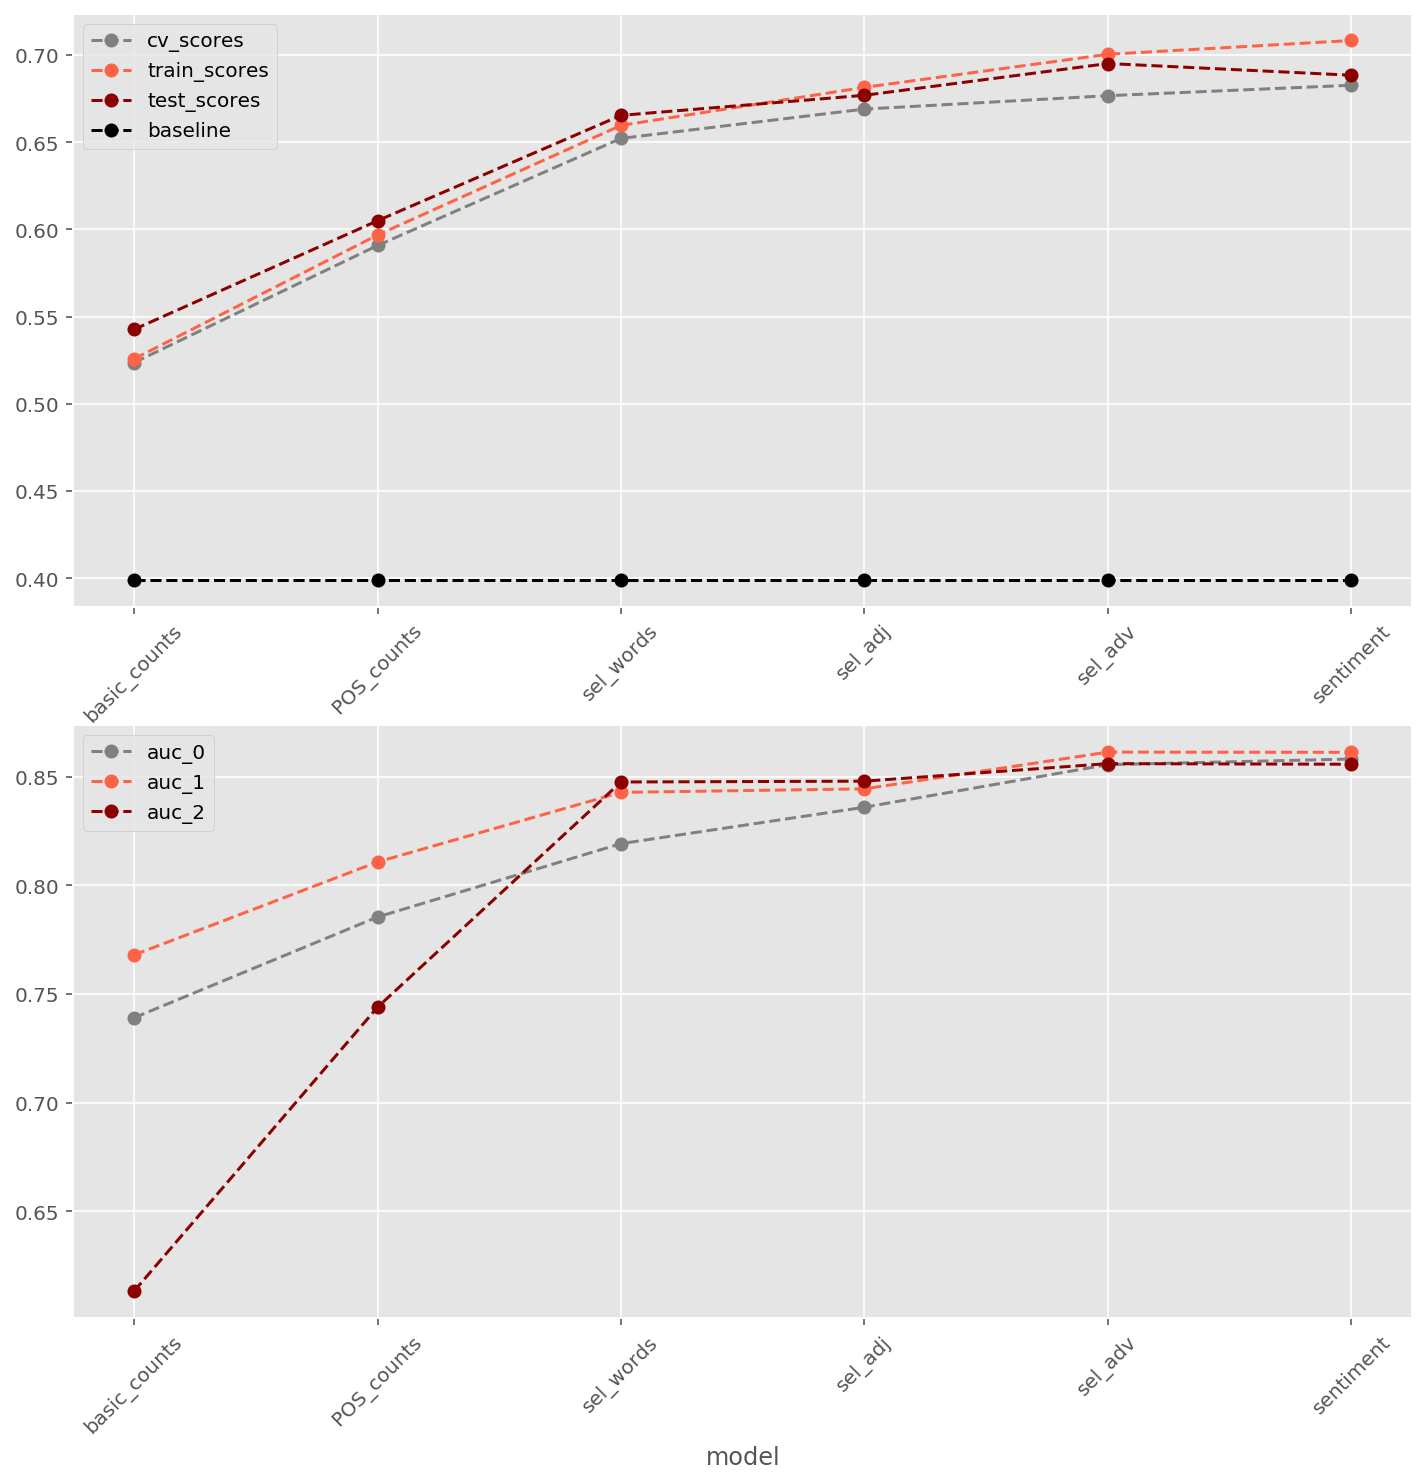

In [40]:
sns.set_palette(['gray', 'tomato', 'darkred', 'black'])
dict_cv_scores = {'model': model_nums, 
                  'cv_scores': cv_scores, 
                  'train_scores': train_scores,
                  'test_scores': test_scores,
                  'auc_0': auc_0,
                  'auc_1': auc_1,
                  'auc_2': auc_2,}
df_cv_scores = pd.DataFrame(dict_cv_scores)
df_cv_scores['baseline'] = baseline_acc

fig, ax = plt.subplots(nrows=2, figsize=(12,12))


df_cv_scores.sort_values(by='model').plot(x='model', y='cv_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='train_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='test_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='baseline', linestyle='--', marker='o', ax=ax[0])

df_cv_scores.sort_values(by='model').plot(x='model', y='auc_0', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_1', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_2', linestyle='--', marker='o', ax=ax[1])

labels = ['', 'basic_counts', 'POS_counts', 'sel_words', 'sel_adj', 'sel_adv', 'sentiment']
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'

ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x', labelrotation=45)




plt.savefig('../../../../Documents/murakami/plots/lreg_sel_feature_scores.png')
plt.show()

In [41]:
predictor_cols = feature_select()
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_01.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

In [42]:
df_coef

coefs_0   coefs_1   coefs_2
n_sents_norm               0.988694 -1.375123  0.352830
n_words_norm              -2.143459  1.365781  0.732967
n_chars_norm               0.335702 -0.831696  0.470283
n_syllables_norm           0.691621 -0.535132 -0.143742
n_unique_words_norm        0.501052 -0.492682  0.029835
n_long_words_norm          0.282484 -0.059959 -0.198871
n_monosyllable_words_norm  1.887557 -0.945568 -0.908704
n_polysyllable_words_norm -0.436819  0.419060  0.005070

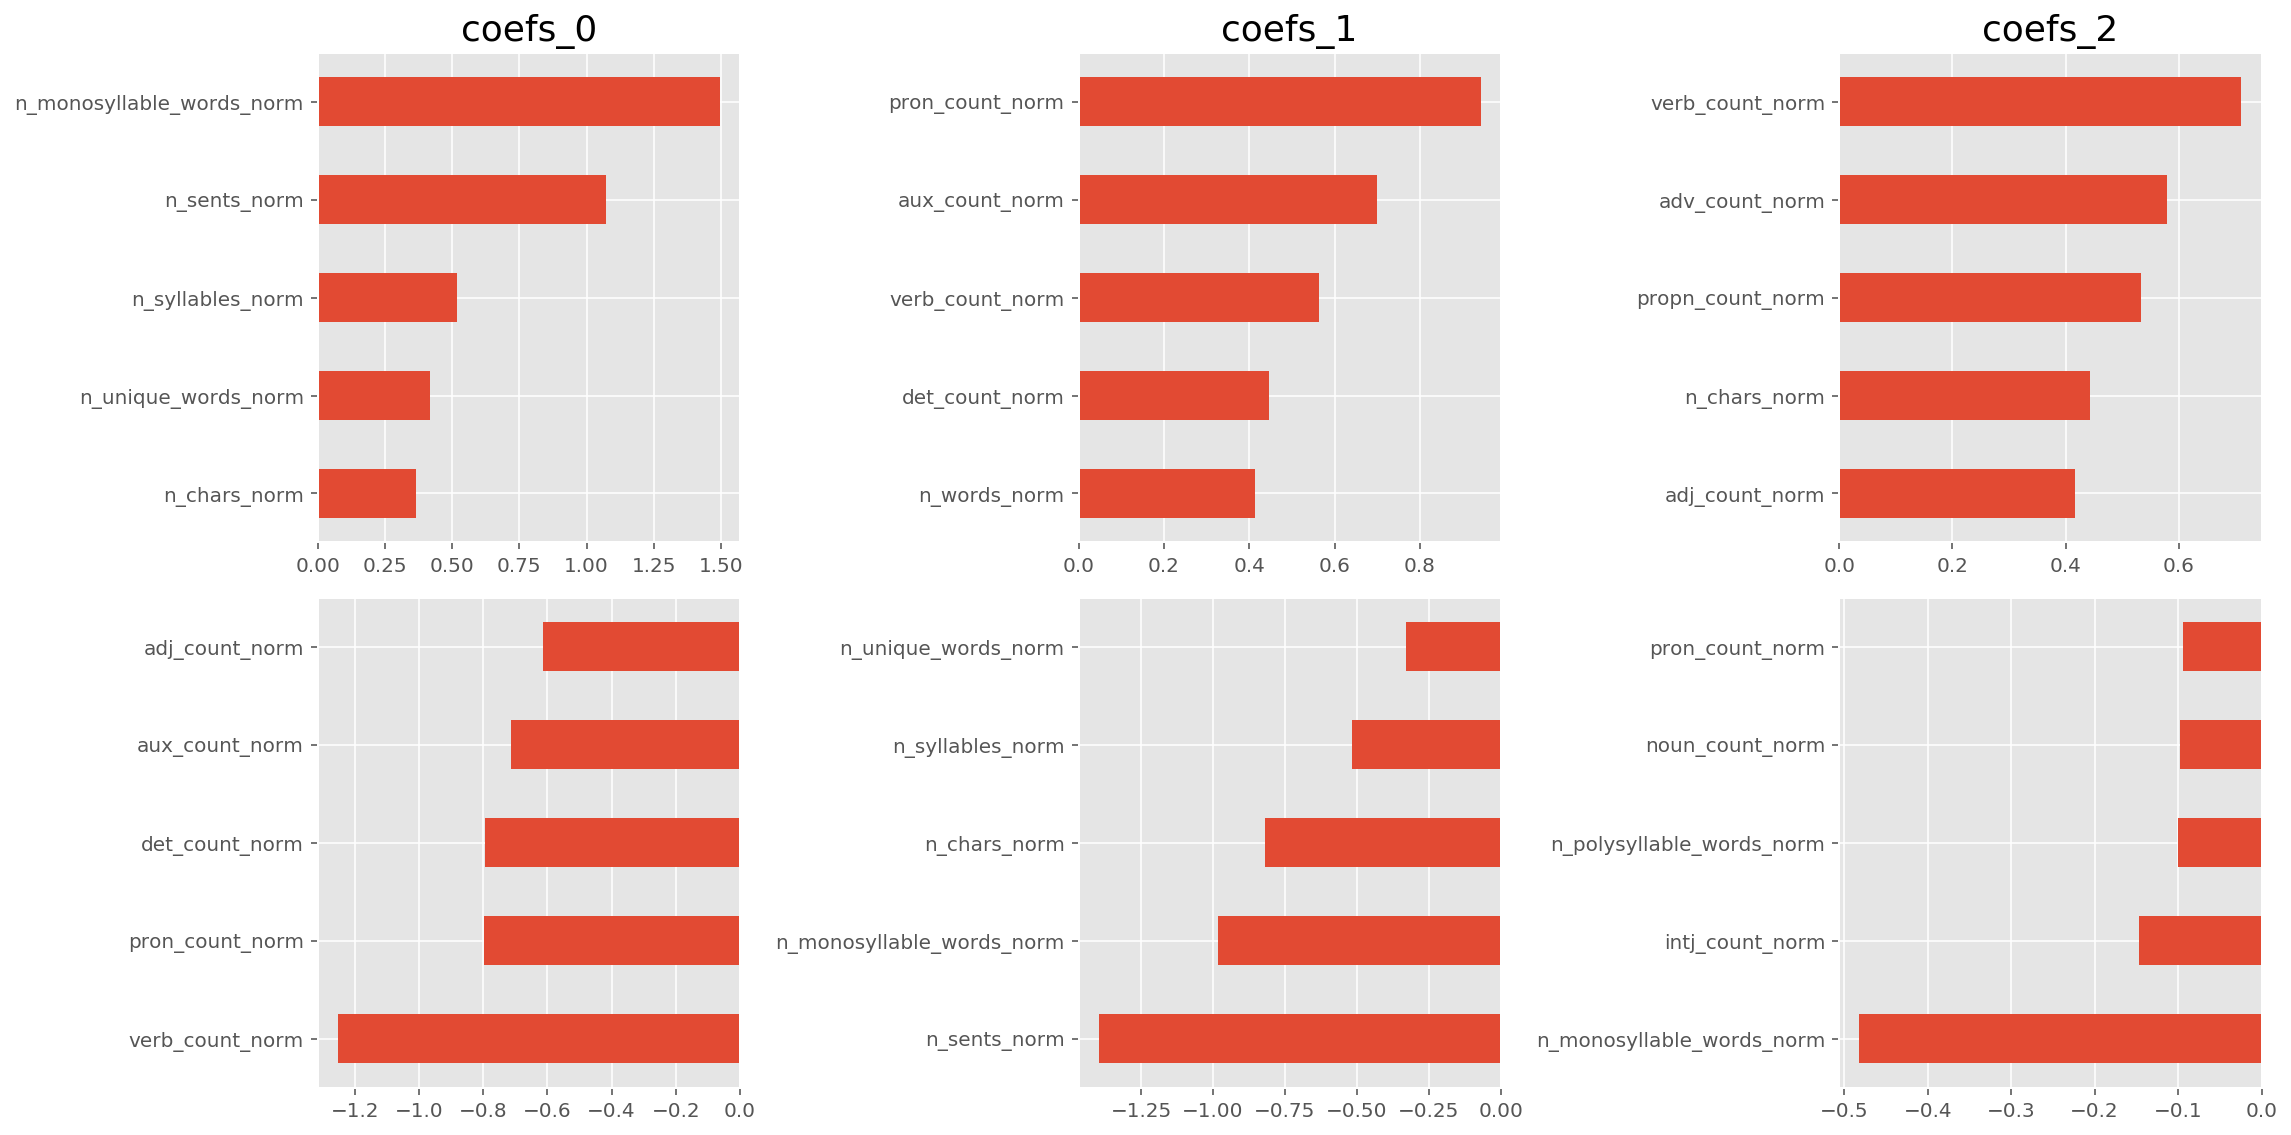

In [45]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

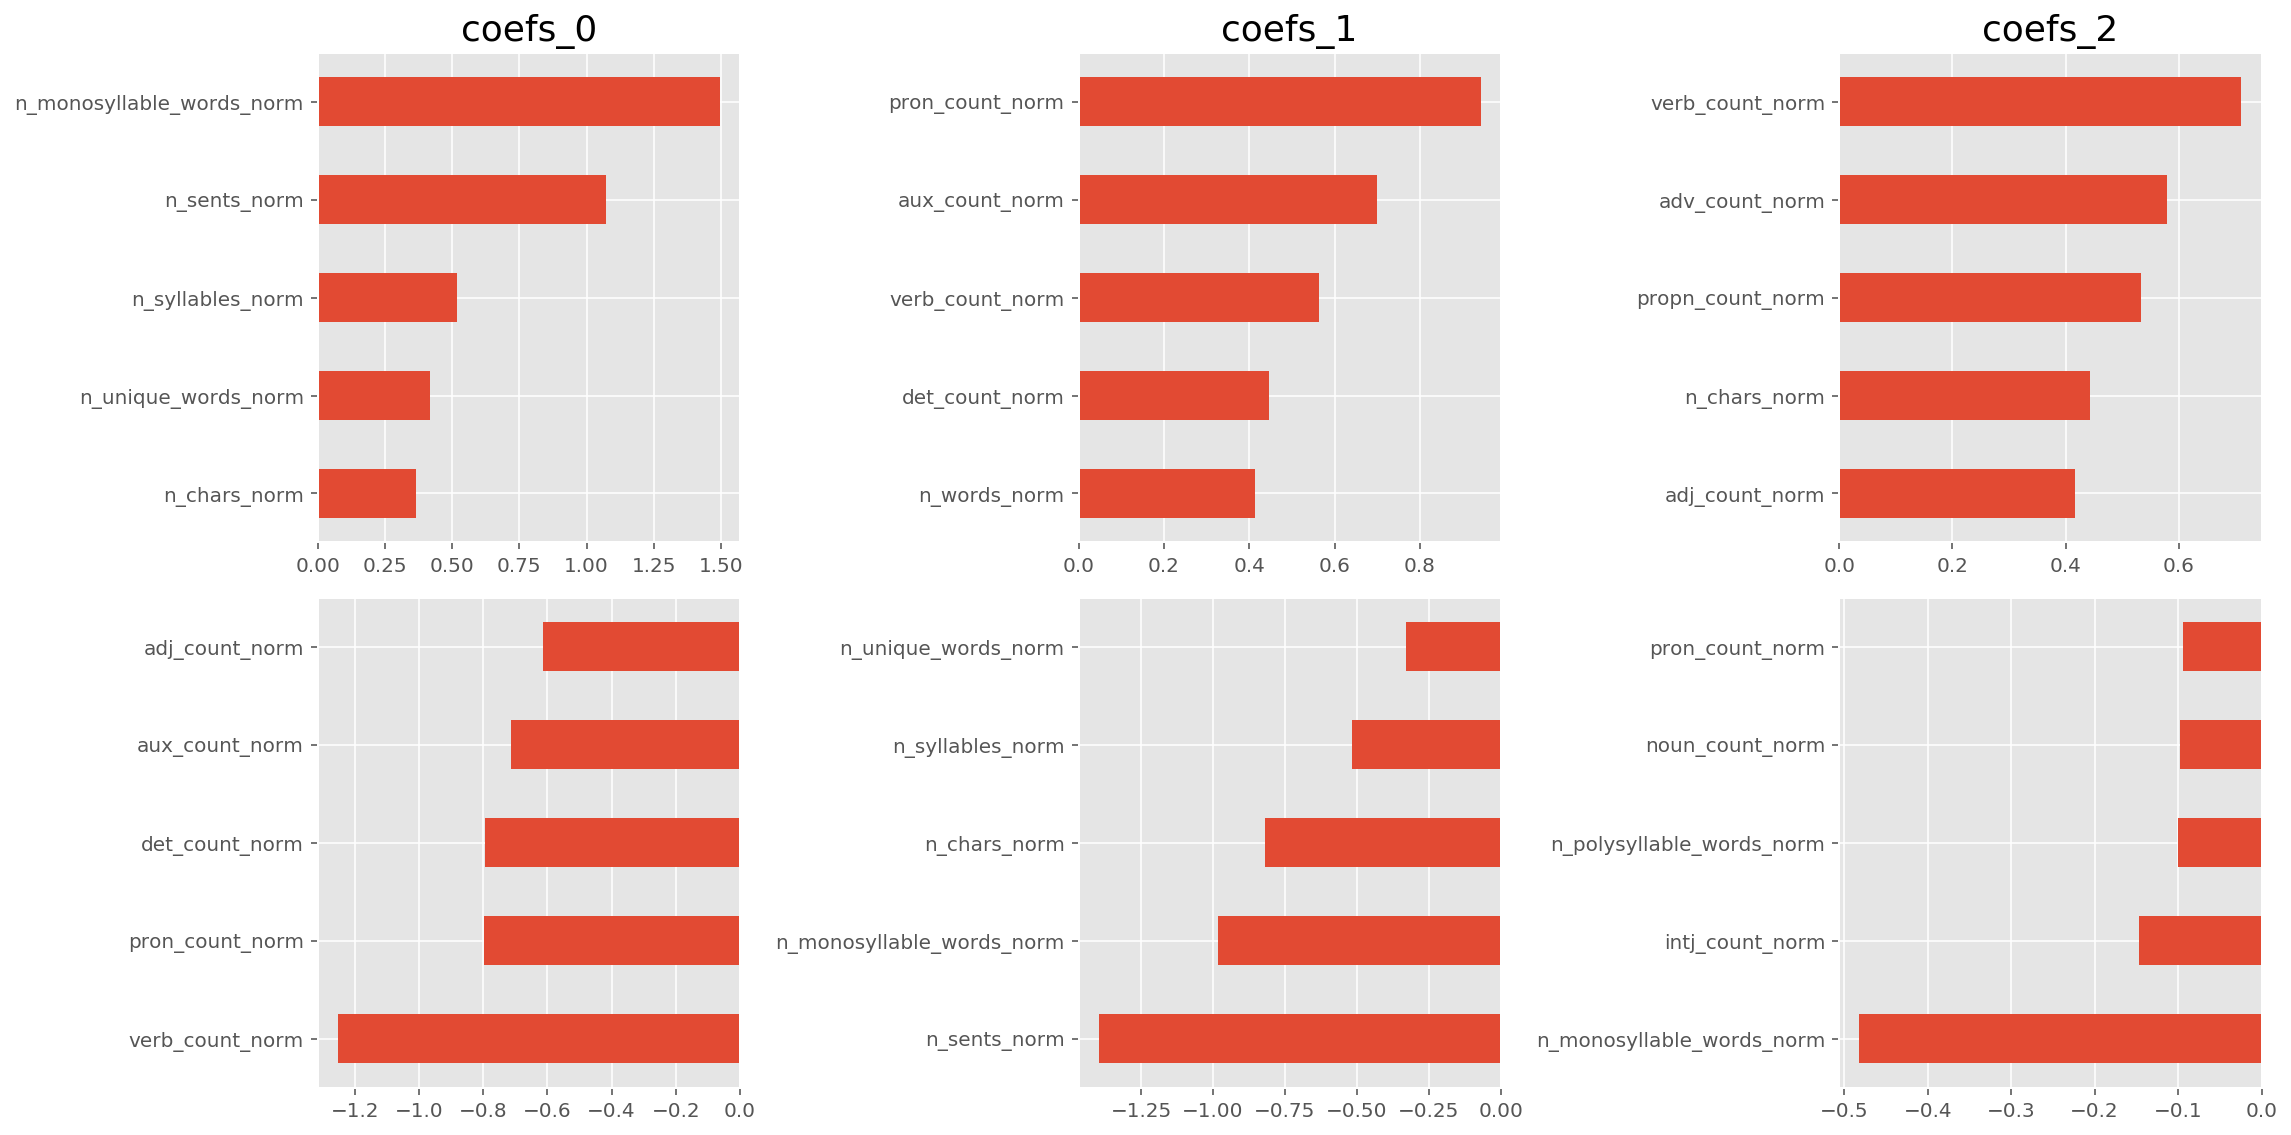

In [46]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_02.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

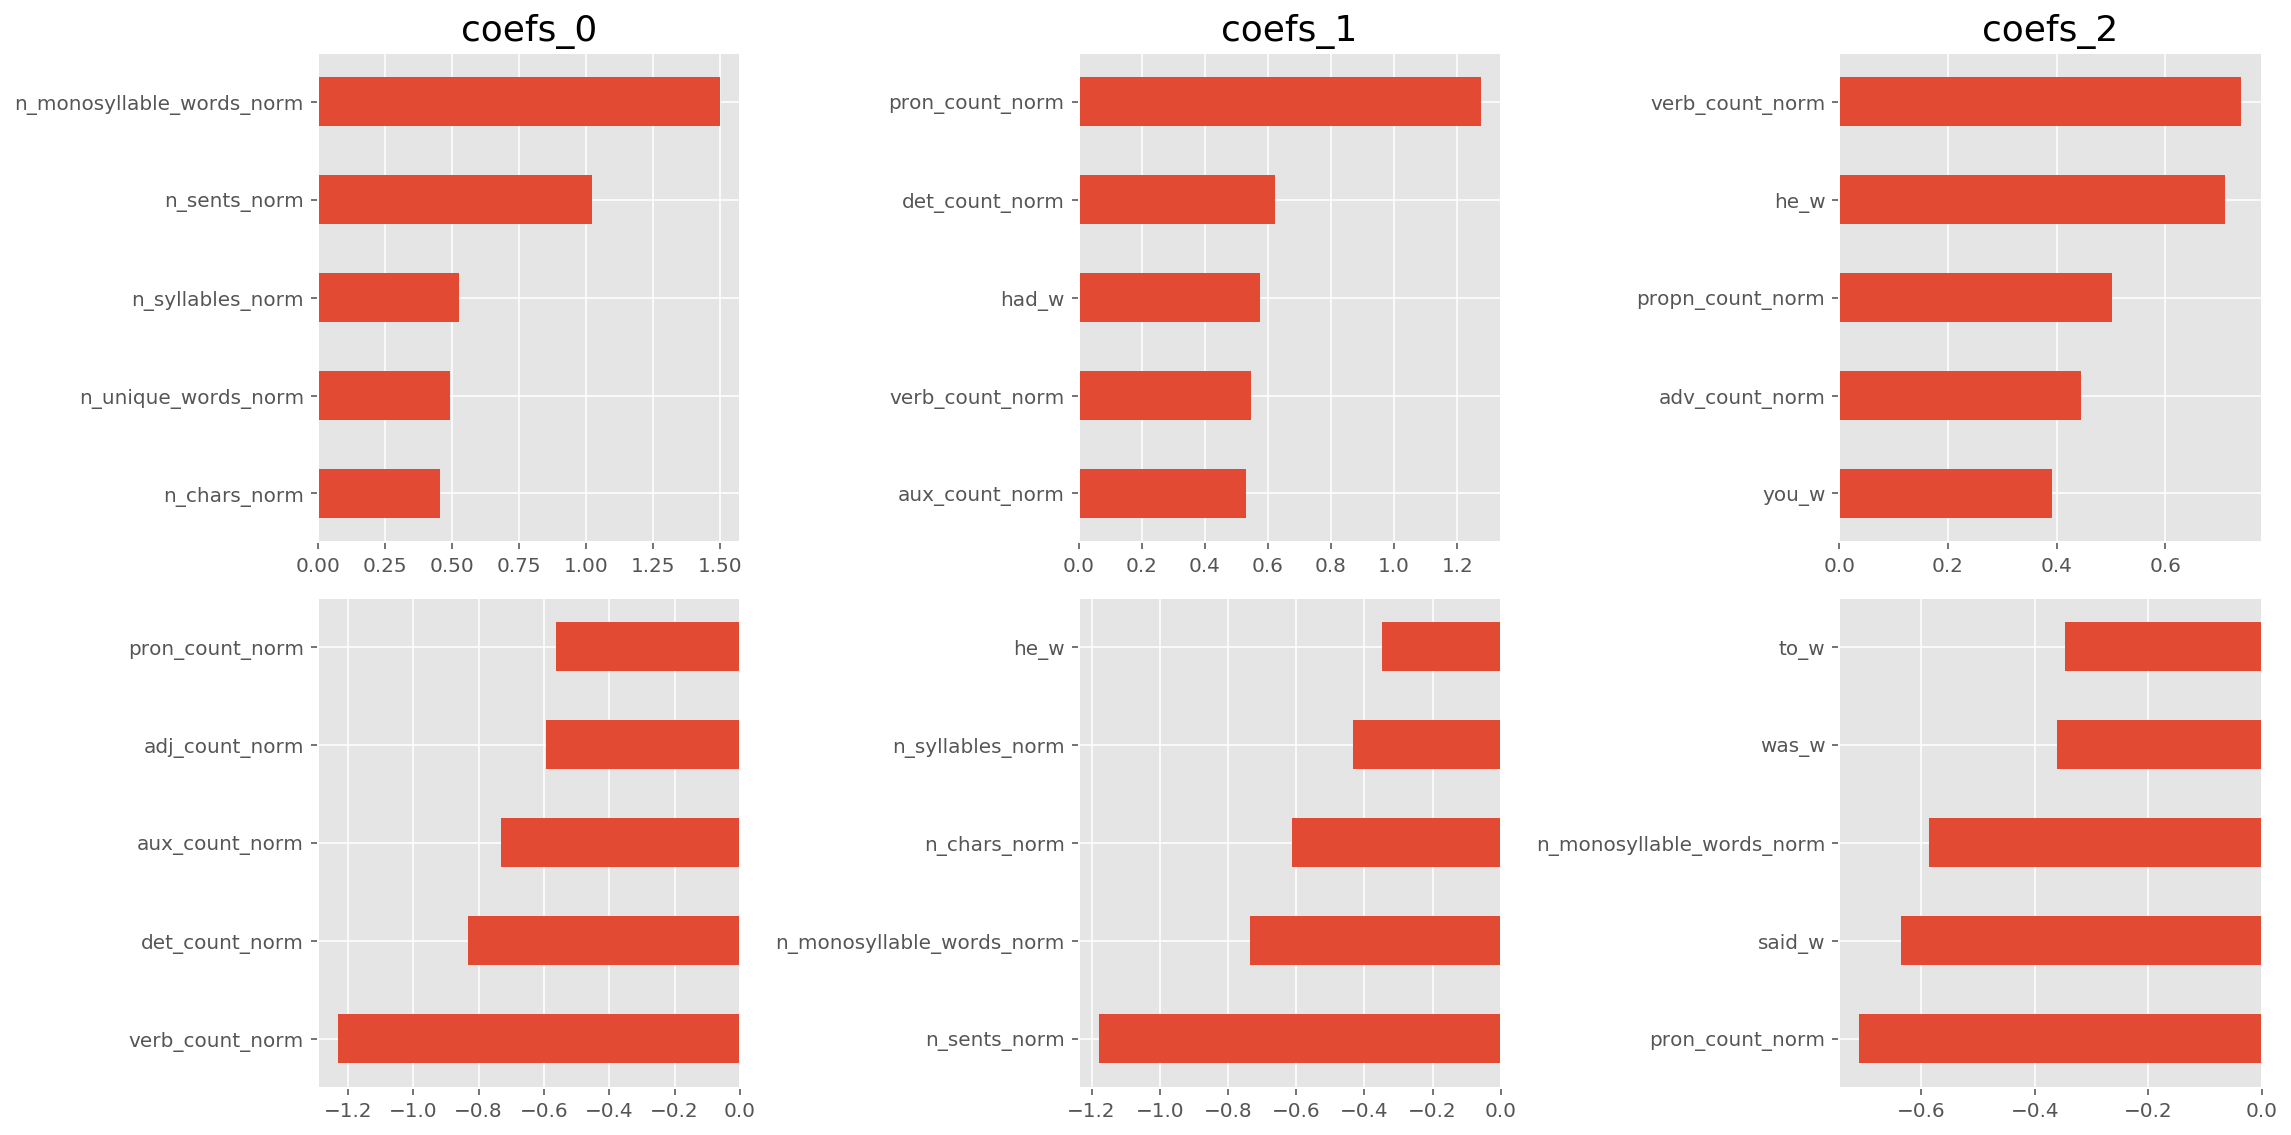

In [47]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_03.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

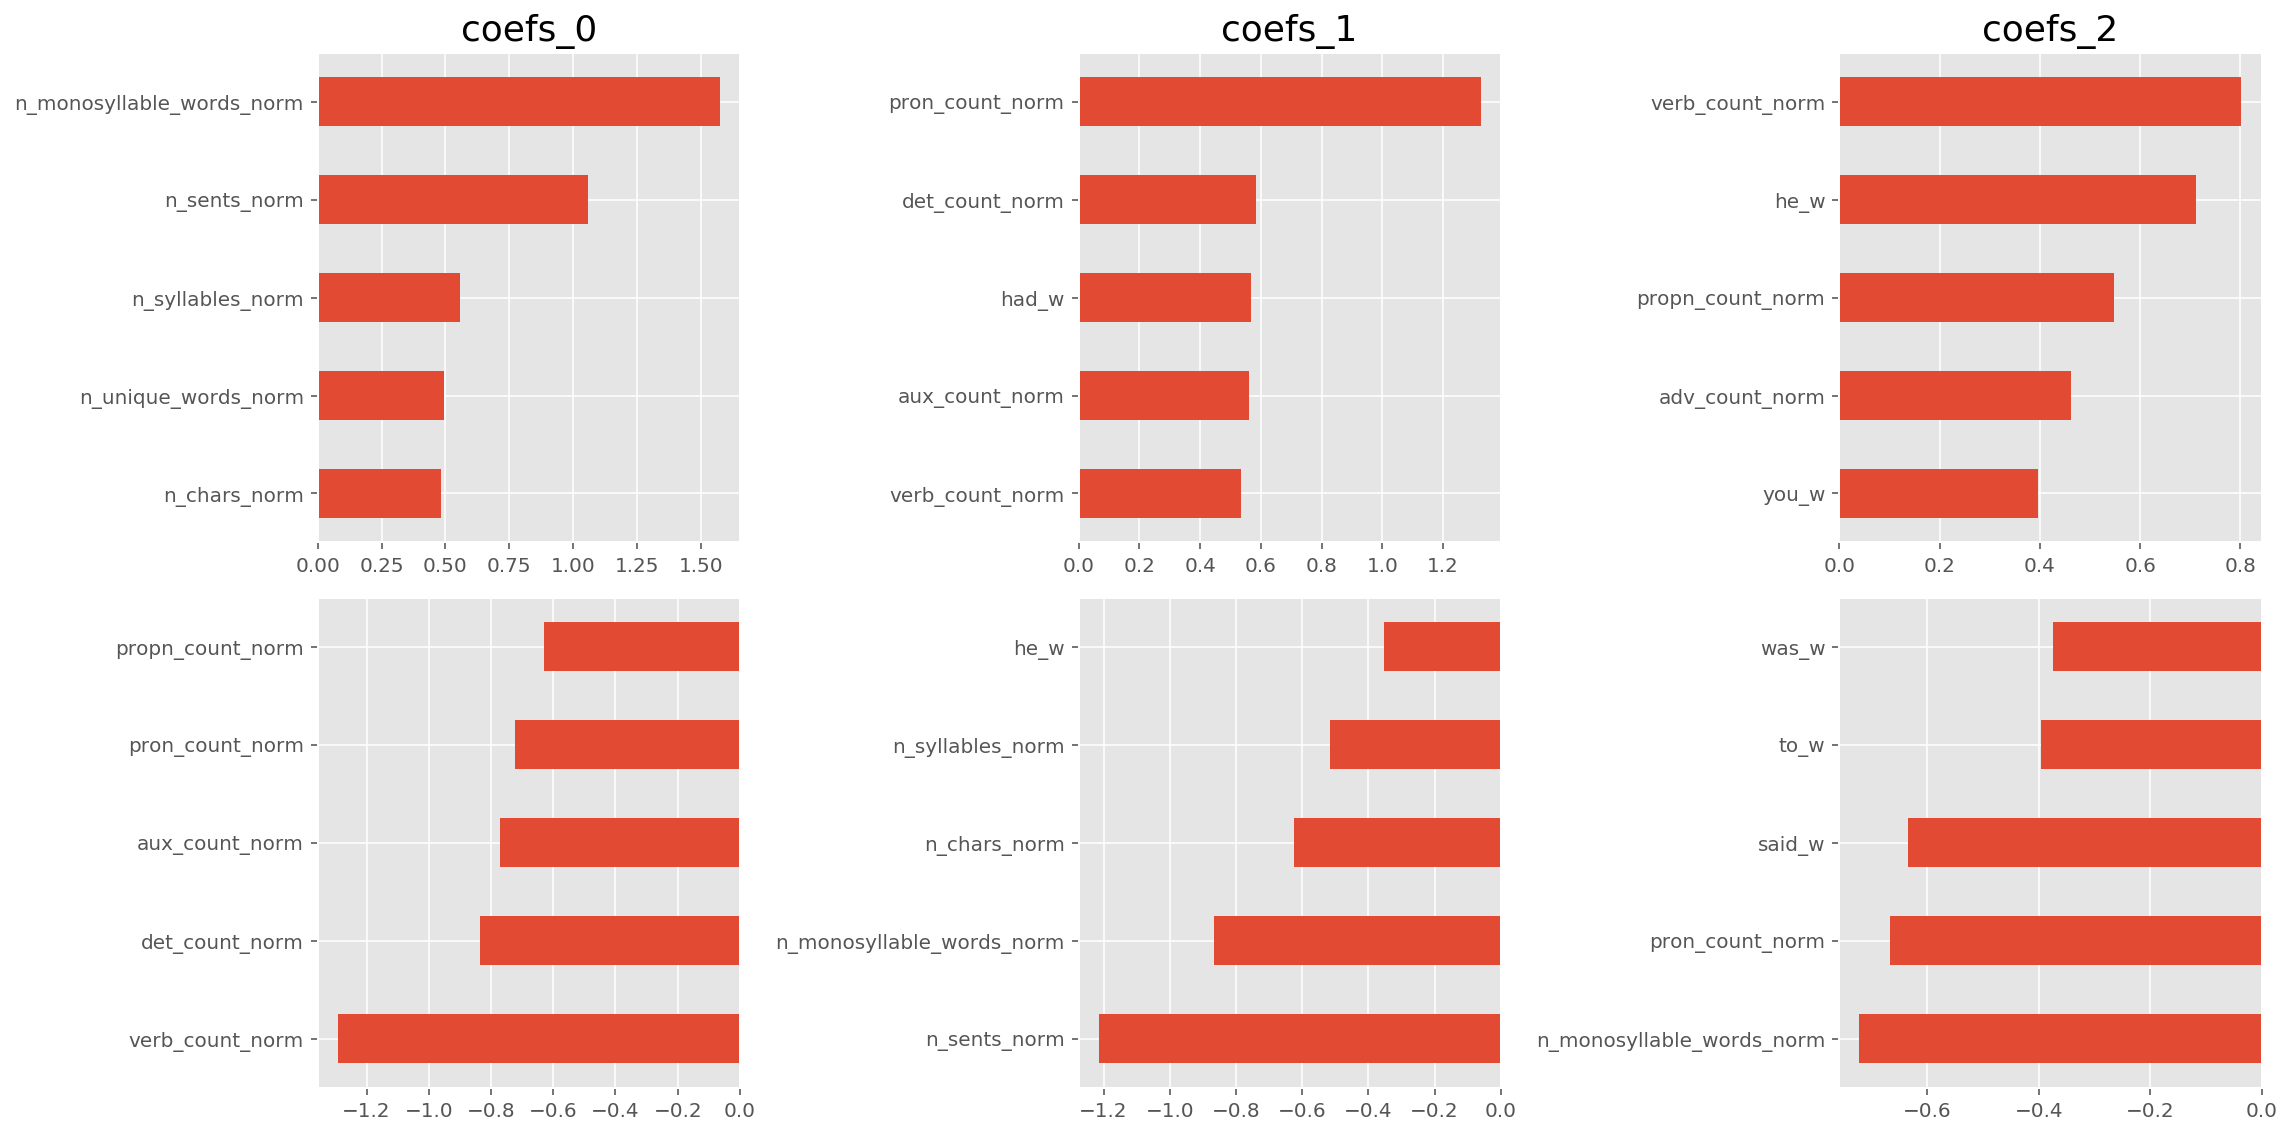

In [48]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_04.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()


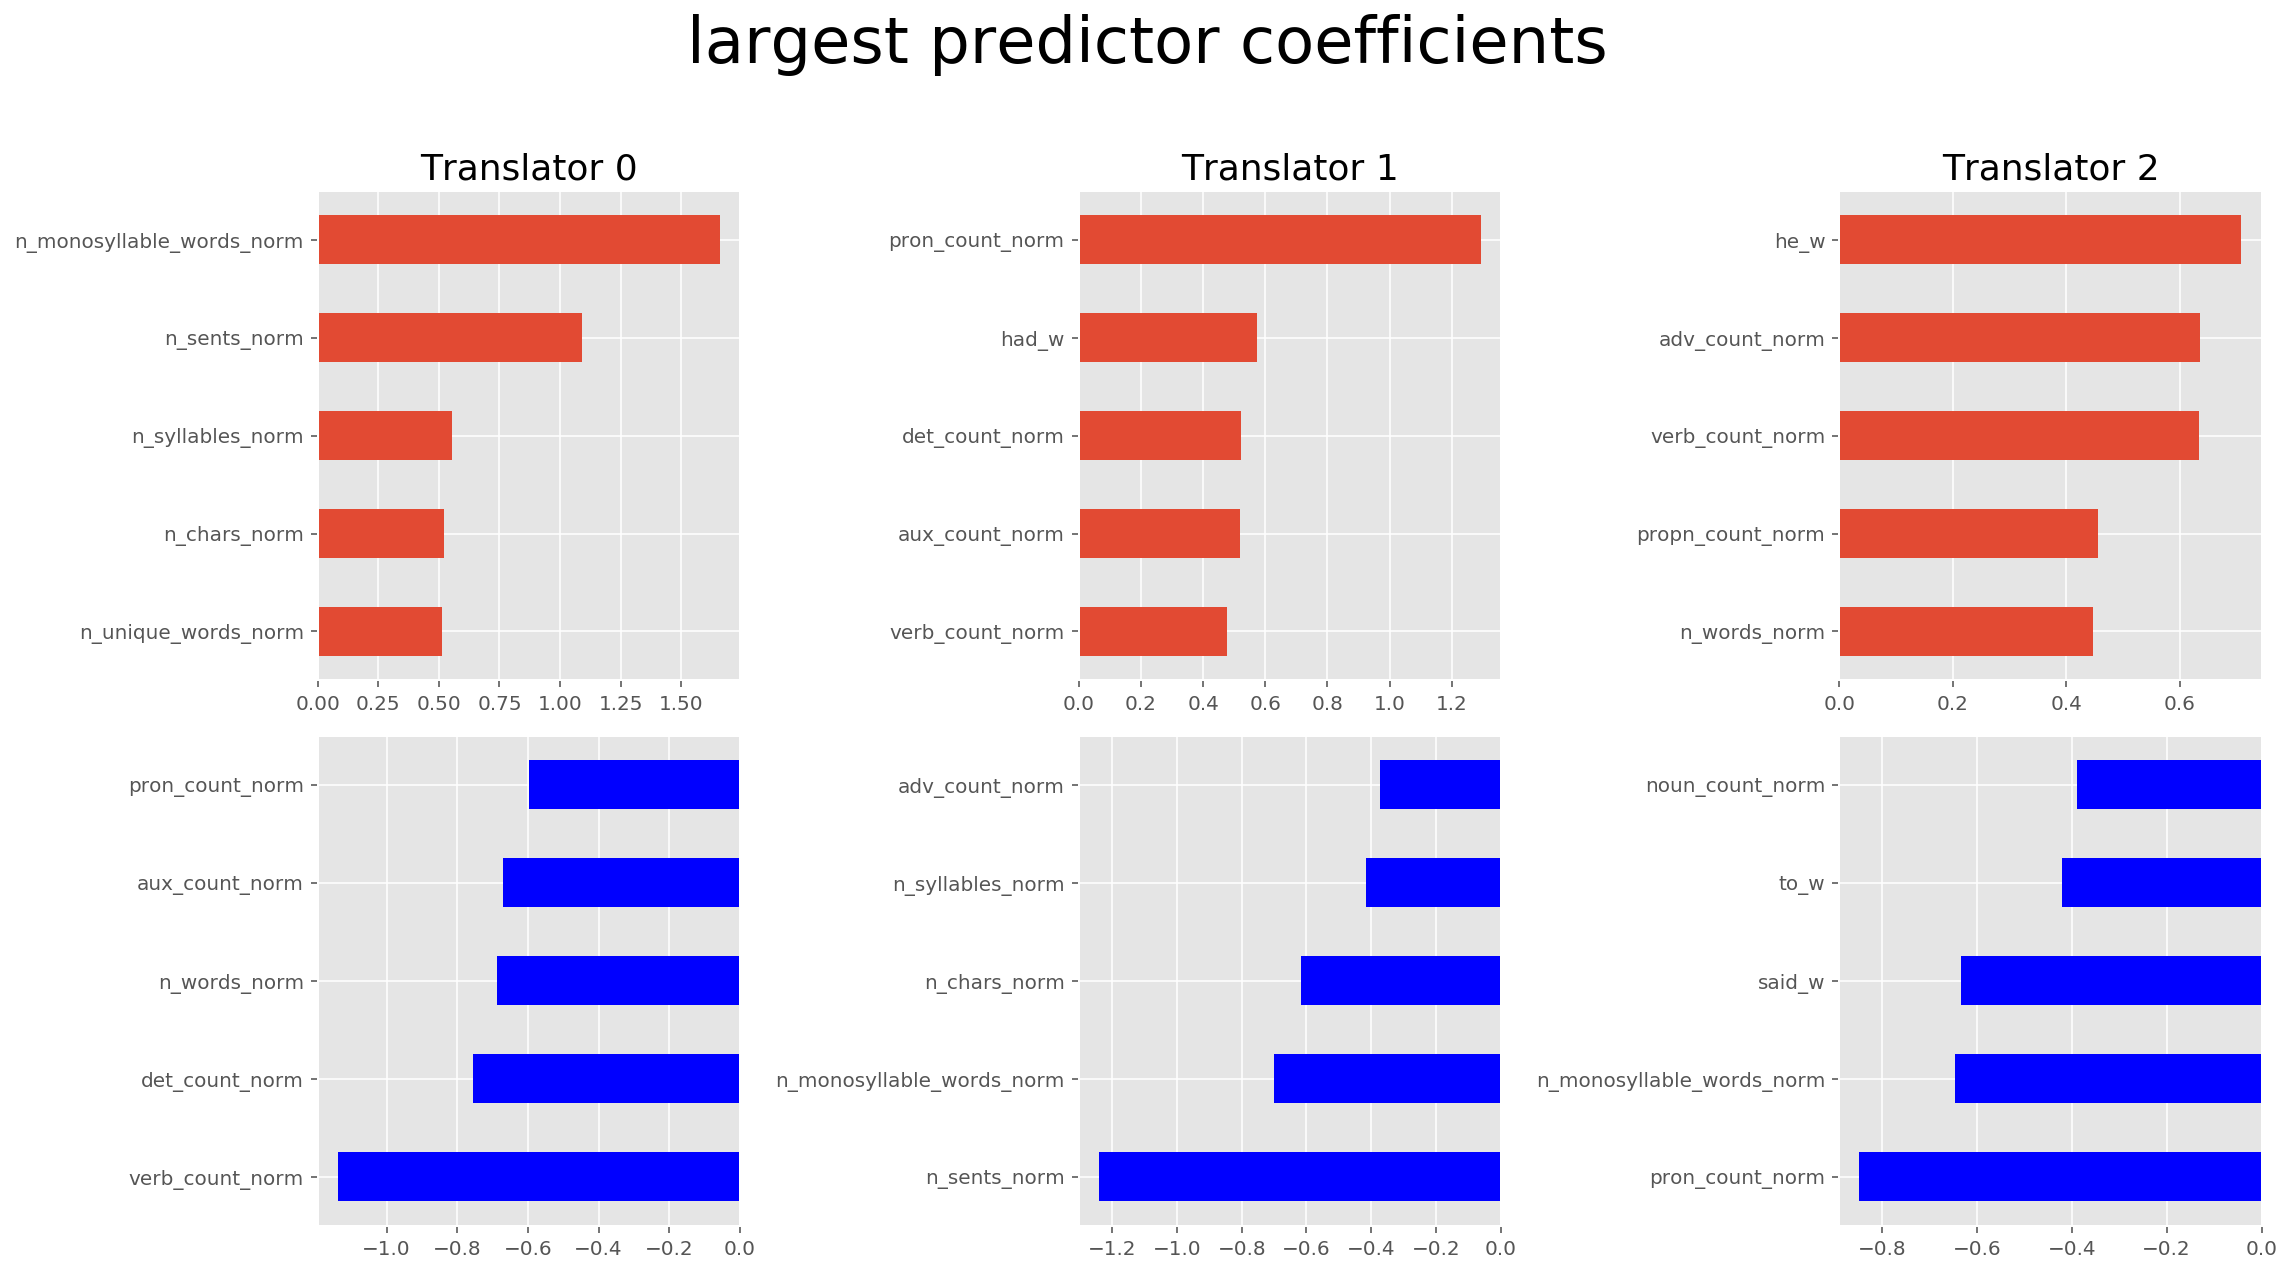

In [49]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_05.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title('Translator ' + str(i), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i], color='b')
fig.suptitle('largest predictor coefficients', fontsize=32, y=1.10)
plt.tight_layout()
plt.show()

In [55]:
# df_coef[col].sort_values(ascending=True)

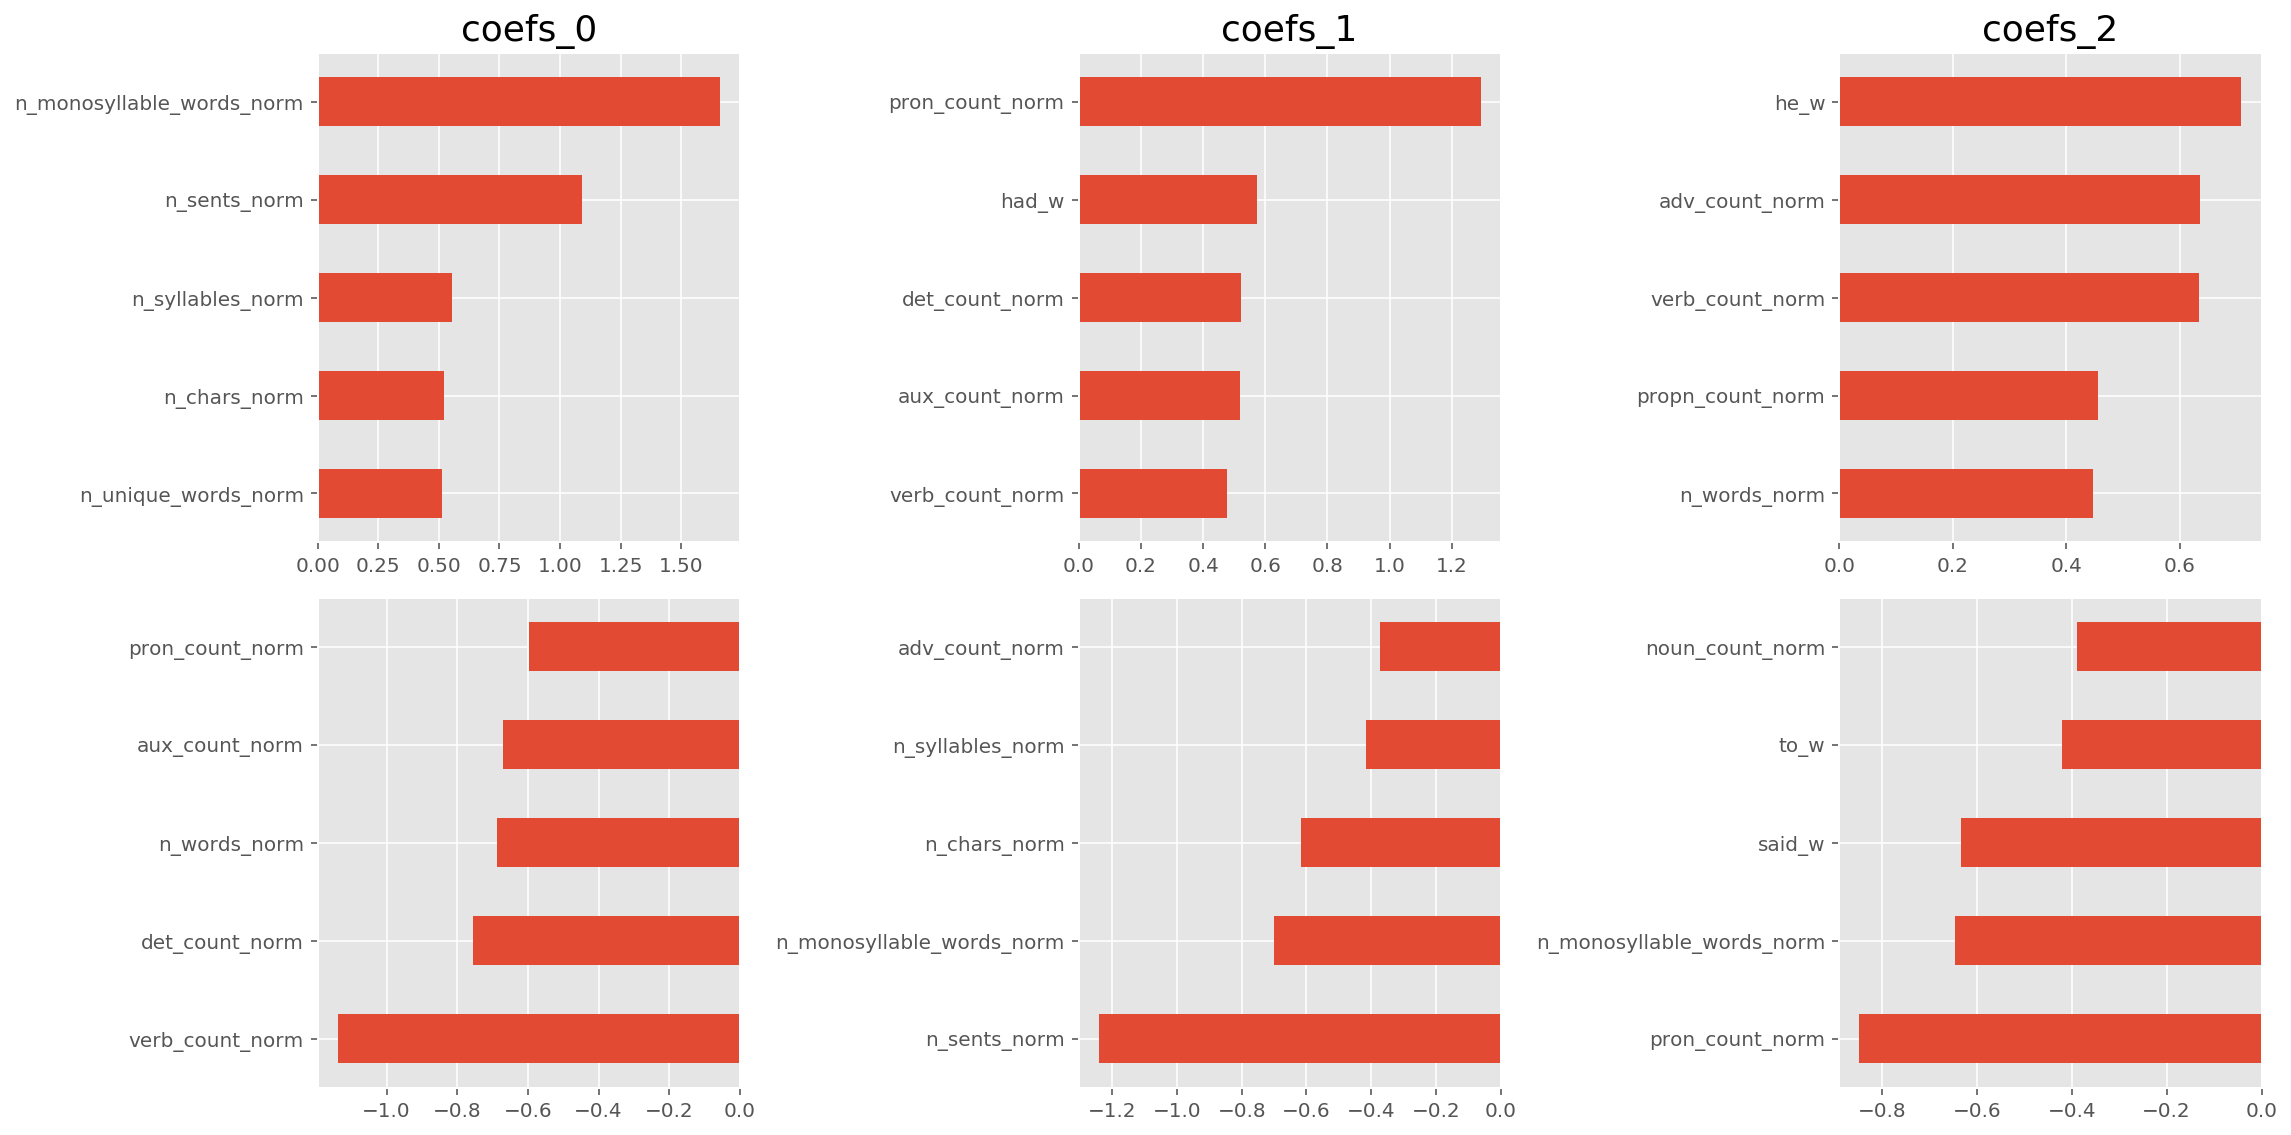

In [50]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_05.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()



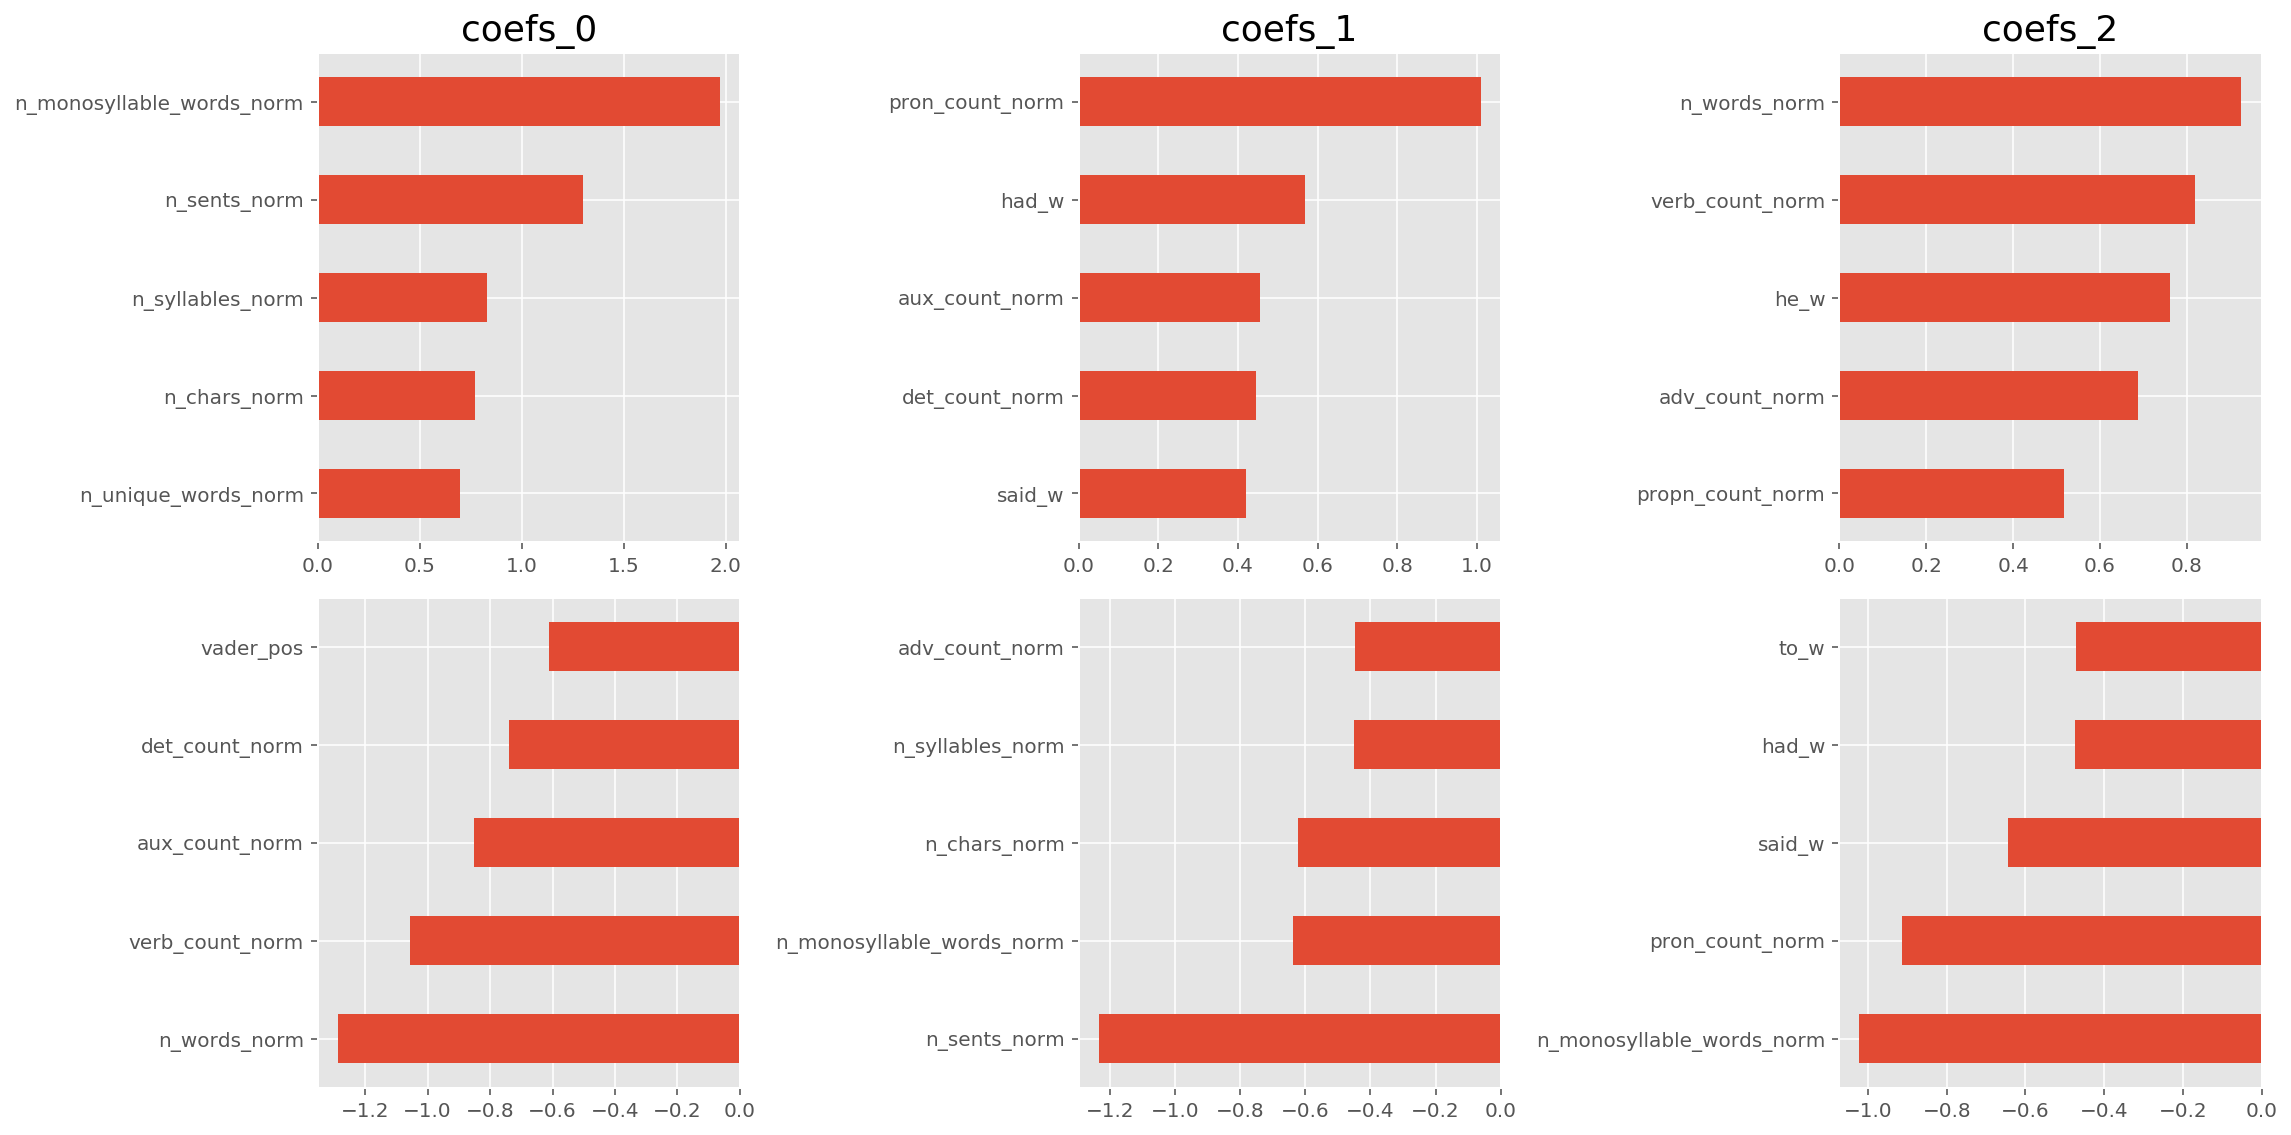

In [57]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True, vader=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_gs_06.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

## Comments on Parameter Coefficients
* vader sentiment scores don't seem to contribute much and risk being linked more to the text itself rather than the translator style which we're interested in
* n_monosyllable_words_norm, n_sents_norm and n_syllables_norm parameters consistently have the highest positive coefficients for predicting translator 0 (Birnbaum). Aux_count verb_count are the highest negative coefficients
* pron_count_norm, n_words_norm and the word 'had' have the highest positive coefficients for predicting translator 1 (Rubin). n_sents and n_monosyllable_words have the highest negative coefficients.
* Aux_count, verb_count, adverb_count and prop_noun_counts have the highest positive coefficients for predicting translator 2 (Gabriel). n_monosyllable_words has the highest negative coefficient

## Run a best logistic regression

In [51]:
lreg_gs_06.best_params_

{'C': 1, 'penalty': 'l1'}

In [52]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

indices = list(df.index)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_final = LogisticRegression(C=1, penalty='l1', solver='liblinear', multi_class='ovr', max_iter=1000)

lreg_final.fit(X_train, y_train)
predictions = lreg_final.predict(X_test)
lreg_final.score(X_test, y_test)

0.6951102588686481

In [60]:
# code could be useful for refactoring some of the code abobe - extracting from tuples/dicts etc to df
# df_pred = pd.DataFrame([(x.r_ui, x.est) for x in predictions_full],
#                        columns=['Rating', 'Predicted'])

In [53]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_final'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_final, fp)

## Review most confidently predicted texts per translator

In [54]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(lreg_final.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp', 'trans_2_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = idx_test
Y_pp.head()

trans_0_pp  trans_1_pp  trans_2_pp  original_index
0    0.632236    0.168252    0.199512            4088
1    0.010042    0.865096    0.124861            2396
2    0.021141    0.923257    0.055602            4107
3    0.057693    0.167128    0.775180            3309
4    0.806587    0.064257    0.129156            4719

In [55]:
Y_pp_merged = Y_pp.merge(df, how='left', left_on='original_index', right_index=True)

In [56]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(5)

trans_0_pp  trans_1_pp  trans_2_pp  \
538     0.955442    0.034903    0.009655   
1038    0.940254    0.036266    0.023480   
1029    0.937488    0.022431    0.040081   
637     0.933857    0.040401    0.025742   
896     0.915019    0.033900    0.051080   

                                                 chunks       translator  \
538   “This job here today’s my last,” I said. “If I...  Alfred Birnbaum   
1038  In fact, it was a while before I even realized...  Alfred Birnbaum   
1029   Huge enough to stop the middle-aged man’s sno...  Alfred Birnbaum   
637    When I moved in, the superintendent said I’d ...  Alfred Birnbaum   
896   “ I HAVE BEEN waiting for you,” said the man i...  Alfred Birnbaum   

                 book_title  book_chunk_no number  
538   The Elephant Vanishes            453     12  
1038  The Elephant Vanishes            375     10  
1029     A Wild Sheep Chase            241     25  
637      A Wild Sheep Chase            144     16  
896      A Wild Sheep Chase            460     43

In [57]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(5)

trans_0_pp  trans_1_pp  trans_2_pp  \
958    0.005004    0.990368    0.004628   
96     0.008987    0.985332    0.005681   
419    0.004800    0.974927    0.020274   
835    0.023054    0.974554    0.002392   
481    0.013773    0.966167    0.020060   

                                                chunks translator  \
958   But there’s something else, something you don...  Jay Rubin   
96   I had had that blank of several years, and whi...  Jay Rubin   
419   While I stood there in shock, he raised the b...  Jay Rubin   
835   Kumiko’s parents were not above interpreting ...  Jay Rubin   
481   Just imagine if you will: for twenty-six year...  Jay Rubin   

                     book_title  book_chunk_no number  
958  The Wind Up Bird Chronicle            674     16  
96               Norwegian Wood            264      2  
419  The Wind Up Bird Chronicle            681     16  
835  The Wind Up Bird Chronicle            691      1  
481  The Wind Up Bird Chronicle            654     14

In [58]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_2_pp', ascending=False).head(5)

trans_0_pp  trans_1_pp  trans_2_pp  \
820    0.019316    0.010445    0.970240   
124    0.021003    0.012562    0.966435   
892    0.045611    0.022958    0.931431   
683    0.071278    0.025731    0.902991   
812    0.028158    0.069323    0.902519   

                                                chunks       translator  \
820   The young man had to drive his truck over to ...   Philip Gabriel   
124   He wasn’t the type of pretty young boy who im...   Philip Gabriel   
892   Eventually he gets out and goes back to his o...   Philip Gabriel   
683  How come these simpletons don’t make an effort...  Alfred Birnbaum   
812   "Everybody calls me Sada," he tells me. He ta...   Philip Gabriel   

                   book_title  book_chunk_no number  
820        Kafka On The Shore            425     22  
124  Colorless Tsukuru Tazaki             72      4  
892        Kafka On The Shore            207     13  
683            Norwegian Wood            115      8  
812        Kafka On The Shore            914     49

## Most confident for translator 0: 
* better now without 'A wild sheep chase' with the strange dialogue!

In [59]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

'“This job here today’s my last,” I said. “If I don’t get myself back on the ball with my studies, my grade point average is going to be in real trouble.” The woman looked me hard in the face, then glanced at my feet, then looked back at my face. “A student, eh?” “Yeah,” I said. “What school?” The name of the university made no visible impression on her. It wasn’t a very impressive university. She just scratched behind her ear with her index finger. “So you’re giving up this line of work, then?” “Yeah, for this summer at least,” I said. No more mowing lawns for me this summer. Nor next summer, nor the next. The woman filled her cheeks with vodka tonic as if she were going to gargle, then gulped down her precious mouthwash half a swallow at a time. Her whole forehead beaded up with sweat, like it was crawling with tiny bugs. “Come inside,” the woman said. “It’s too hot outdoors.” I looked at my watch. Two thirty-five. Getting late? Still early? I couldn’t make up my mind. I’d already fi

In [60]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[1,3]

'In fact, it was a while before I even realized he’d lit my cigarette. “What line of work you in?” “Business,” I said. His mouth fell open and the word formed a second or two later. “Business?” “Yeah. Nothing much to speak of.” I let it slide. He nodded and left it at that. It wasn’t that I didn’t want to talk about work. I just didn’t feel like starting in on what promised to be another escapade. I was tired, and I didn’t even know the guy’s name. “That surprises me. You in business. I wouldn’t have figured you for a businessman.” I smiled. “Used to be that all you did was read books,” he went on, with a bit of mystery. “Well, I still read a lot.” I forced a laugh. “Encyclopedias?” “Encyclopedias?” “Sure, you got an encyclopedia?” “No.” I shook my head, not comprehending. “You don’t read encyclopedias?” “Maybe if there’s one around,” I said. Of course, in the place I was living there wouldn’t be any room to have one around. “Actually, I sell encyclopedias,” he said. Oh, boy, an encycl

In [61]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[2,3]

' Huge enough to stop the middle-aged man’s snoring for a moment. A pair of high school girls giggled. By reflex, I thought of Kipper. And it was only when I did that it came to me that we’d really left Tokyo and were now in Sapporo. Funny about that. Amid these thoughts I fell asleep. In my dreams, I encountered that green devil, but he wasn’t endearing in the least. He remained silent and I just observed his machinations. Meanwhile, the film ended, the lights came on, and I woke up. Each member of the audience yawned as if in predetermined order. I went to the snack bar and bought ice cream for us. It was hard as a rock, probably left over from last summer. “You slept through the whole thing?” “Uh-huh,” I said. “How was it?” “Pretty interesting. In the end, the whole town explodes.” “Wow.” The movie theater was deathly quiet. Or rather everything around us was deathly quiet. Not a common occurrence.'

## Most confident for translator 1

In [62]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,3]

' But there’s something else, something you don’t know about, something I can’t put into words just yet. I’m not hiding anything from you. I just can’t be sure whether or not it’s something real. Which is why I can’t put it into words yet . Back then, she couldn’t be sure that that something was real. And that something , without a doubt, had been more connected with the pregnancy than with the abortion. Maybe it had had something to do with the child in her womb. What could it have been? What had sent her into such confusion? Had she had relations with another man and refused to give birth to his baby? No, that was out of the question. She herself had declared that it was out of the question. It had been my child, that was certain. But still, there had been something she was unable to tell me. And that something was inextricably connected to her decision to leave me. Everything had started from that. But what the secret was, what had been concealed there, I had no idea.'

In [63]:
# import re
# test_txt_2 = re.sub("\'","’",test_txt)
# test_txt_2


In [64]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[1,3]

'I had had that blank of several years, and while it might have made sense for me to take on an absolute beginner, it would have been impossible for me to pick up with someone who had had lessons for a number of years. Besides, I was too busy taking care of my own child and. though I didn’t say this to the woman, nobody can deal with the kind of child who changes teachers constantly. So then the woman asked me to at least do her daughter the favour of meeting her once. She was a fairly pushy lady and I could see she was not going to let me off the hook that easily, so I agreed to meet the girl - but just meet her. Three days later the girl came to the house by herself. She was an absolute angel, with a kind of pure, sweet, transparent beauty. I had never - and have never - seen such a beautiful little girl. She had long, shiny hair as black as freshly ground Indian ink, slim, graceful arms and legs, bright eyes, and a soft little mouth that looked as if someone had just made it. I coul

In [65]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[2,3]

' While I stood there in shock, he raised the bat again and swung it at me. I tried to dodge, but I was too late. This time the bat hit my left arm. For a moment, the arm lost all feeling. There was no pain, nothing at all. It was as if the whole arm had just melted into space. Before I knew it, though, almost as a reflex action, I was kicking at him. I had never had formal training in martial arts, but a friend of mine in high school with some proficiency in karate had taught me a few elementary moves. Day after day, he had had me practising kicks – nothing fancy: just training to kick as hard and high and straight as possible. This was the single most useful thing to know in an emergency, he had said. And he was right. Absorbed with swinging his bat, the man had never anticipated the possibility that he might be kicked. Just as frantic as he was, I had no idea where my kick was aimed, nor was it very strong, but the shock of it seemed to take the wind out of him.'

## Most confident for translator 2

In [66]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[0,3]

' The young man had to drive his truck over to the warehouse to deliver his load of furniture, so he told Nakata to wait for him at a small park near the harbor. "Don’t move from here, okay?" Hoshino cautioned him. "There’s a restroom over there, and a water fountain. You got everything you need. If you wander off somewhere, you might not find your way back." "I understand. I’m not in Nakano Ward anymore." "Exactly. This isn’t Nakano. So sit tight, and I’ll be back real soon." "All right. I’ll stay right here." "Good. I’ll be back as soon as I finish my delivery." Nakata did as he was told, not moving from the bench, not even to use the restroom. He didn’t find staying put in one place for a long time very hard. Sitting still, in fact, was his specialty. He could see the sea from where he sat. This he hadn’t seen for a long, long time. When he was little, he and his family had gone to the seaside any number of times. He’d put on trunks, splash around on the shore, gather seashells at l

In [67]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[1,3]

' He wasn’t the type of pretty young boy who immediately grabbed people’s attention, but one whose graceful beauty only became apparent over time. Haida’s hair was short and slightly curly, and he always dressed casually in the same chinos and light-colored shirts. But despite his simple, ordinary outfit, he knew how to wear his clothes well. He loved reading above all else, and, like Tsukuru, he seldom read novels. His preferences ran to philosophy and the classics. He enjoyed reading plays, too, and was a big fan of Greek tragedies and Shakespeare. He also knew Noh and bunraku well. Haida was from Akita Prefecture in the far north of Japan. He had very white skin and long fingers. Like Tsukuru, he couldn’t hold his liquor well, but unlike Tsukuru, he was able to distinguish between the music of Mendelssohn and the music of Schumann. Haida was extremely shy, and when he was together with more than three people, he did his best to stay invisible.'

In [68]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[2,3]

' Eventually he gets out and goes back to his old life. But nothing in the novel shows he learned anything from these experiences, that his life changed, that he thought deeply now about the meaning of life or started questioning society or anything. You don’t get any sense, either, that he’s matured. You have a strange feeling after you finish the book. It’s like you wonder what Soseki was trying to say. It’s like not really knowing what he’s getting at is the part that stays with you. I can’t explain it very well." "So The Miner’s structured very differently from, say, Soseki’s Sanshiro, your typical modern bildungsroman?" I nod. "I don’t know about that, but you might be right. Sanshiro grows up in the story. Runs into obstacles, ponders things, overcomes difficulties, right? But the hero of The Miner’s different. All he does is watch things happen and accept it all. I mean, occasionally he gives his own opinions, but nothing very deep. Instead, he just broods over his love affair.'

## Look at key predictor values for most confident results

In [69]:
top_b = Y_pp_merged.sort_values('trans_0_pp', ascending=False).head(1)
top_b

trans_0_pp  trans_1_pp  trans_2_pp  original_index  book_chunk_no number  \
538    0.955442    0.034903    0.009655            2331            453     12   

    title                                               text  \
538    12  I MUST HAVE been eighteen or nineteen when I m...   

                                         fstop_indices  \
538  [94, 111, 182, 425, 495, 517, 553, 612, 632, 6...   

                                         split_indices  \
538  [968, 1923, 2976, 3966, 4955, 5893, 6943, 7934...   

                                                chunks       translator  \
538  “This job here today’s my last,” I said. “If I...  Alfred Birnbaum   

                book_title                                             parsed  \
538  The Elephant Vanishes  (“, This, job, here, today, ’s, my, last, ,, ”...   

     n_sents  n_words  n_chars  n_syllables  n_unique_words  n_long_words  \
538       23      198      779          247             121            20   

     n_monosyllable_words  n_polysyllable_words  trans_code  chunk_length  \
538                   157                     6           0          1023   

     n_sents_norm  n_words_norm  n_chars_norm  n_syllables_norm  \
538     22.482893    193.548387    761.485826        241.446725   

     n_unique_words_norm  n_long_words_norm  n_monosyllable_words_norm  \
538            118.27957          19.550342                 153.470186   

     n_polysyllable_words_norm  vader_compound  vader_neg  vader_neu  \
538                   5.865103          0.8265      0.037      0.898   

     vader_pos  pron_count  verb_count  det_count  adj_count  num_count  \
538      0.065        19.0        25.0       32.0       13.0        3.0   

     punct_count  noun_count  adp_count  cconj_count  sconj_count  adv_count  \
538         56.0        42.0       25.0          2.0          4.0       16.0   

     aux_count  part_count  propn_count  ...  very_adv  now_adv  when_adv  \
538        7.0         5.0          1.0  ...         1        0         0   

     never_adv  even_adv  why_adv  too_adv  still_adv  so_adv  as_adv  \
538          0         0        0        1          1       1       0   

     how_adv  maybe_adv  here_adv  only_adv  more_adv  back_adv  where_adv  \
538        0          0         1         0         0         1          0   

     then_adv  again_adv  there_adv  just_adv  next_adj  few_adj  sure_adj  \
538         4          0          0         1         2        0         0   

     able_adj  whole_adj  much_adj  first_adj  own_adj  deep_adj  little_adj  \
538         0          1         0          0        0         0           0   

     same_adj  last_adj  strange_adj  small_adj  bad_adj  long_adj  good_adj  \
538         0         1            0          0        0         0         0   

     big_adj new_adj different_adj hard_adj old_adj  young_adj  only_adj  \
538        0       0             0        1       0          0         0   

     more_adj  other_adj  right_adj  real_adj  vlong_words_count  
538         1          0          0         1                  0  

[1 rows x 146 columns]

In [70]:
top_r = Y_pp_merged.sort_values('trans_1_pp', ascending=False).head(1)
top_r

trans_0_pp  trans_1_pp  trans_2_pp  original_index  book_chunk_no number  \
958    0.005004    0.990368    0.004628            3089            674     16   

                                                 title  \
958  The Simplest Thing \n • \n Revenge in a Sophis...   

                                                  text  \
958  THE NEXT DAY  I called my uncle and told him I...   

                                         fstop_indices  \
958  [110, 243, 288, 454, 546, 587, 707, 763, 817, ...   

                                         split_indices  \
958  [965, 1928, 2910, 3997, 4969, 5946, 6960, 7901...   

                                                chunks translator  \
958   But there’s something else, something you don...  Jay Rubin   

                     book_title  \
958  The Wind Up Bird Chronicle   

                                                parsed  n_sents  n_words  \
958  ( , But, there, ’s, something, else, ,, someth...       17      189   

     n_chars  n_syllables  n_unique_words  n_long_words  n_monosyllable_words  \
958      774          238              89            30                   151   

     n_polysyllable_words  trans_code  chunk_length  n_sents_norm  \
958                     9           1           984     17.276423   

     n_words_norm  n_chars_norm  n_syllables_norm  n_unique_words_norm  \
958    192.073171    786.585366        241.869919            90.447154   

     n_long_words_norm  n_monosyllable_words_norm  n_polysyllable_words_norm  \
958          30.487805                 153.455285                   9.146341   

     vader_compound  vader_neg  vader_neu  vader_pos  pron_count  verb_count  \
958          0.6583      0.049       0.88      0.071        38.0        22.0   

     det_count  adj_count  num_count  punct_count  noun_count  adp_count  \
958       20.0        8.0        0.0         27.0        18.0       16.0   

     cconj_count  sconj_count  adv_count  aux_count  part_count  propn_count  \
958          7.0          6.0       13.0       29.0        11.0          0.0   

     ...  very_adv  now_adv  when_adv  never_adv  even_adv  why_adv  too_adv  \
958  ...         0        0         0          0         0        1        0   

     still_adv  so_adv  as_adv  how_adv  maybe_adv  here_adv  only_adv  \
958          1       0       0        0          1         0         0   

     more_adv  back_adv  where_adv  then_adv  again_adv  there_adv  just_adv  \
958         1         1          0         1          0          1         2   

     next_adj  few_adj  sure_adj  able_adj  whole_adj  much_adj  first_adj  \
958         0        0         2         0          0         0          0   

     own_adj  deep_adj  little_adj  same_adj  last_adj  strange_adj  \
958        0         0           0         0         0            0   

     small_adj  bad_adj  long_adj  good_adj  big_adj new_adj different_adj  \
958          0        0         0         0        0       0             0   

    hard_adj old_adj  young_adj  only_adj  more_adj  other_adj  right_adj  \
958        0       0          0         0         0          0          0   

     real_adj  vlong_words_count  
958         2                  0  

[1 rows x 146 columns]

In [71]:
top_g = Y_pp_merged.sort_values('trans_2_pp', ascending=False).head(1)
top_g

trans_0_pp  trans_1_pp  trans_2_pp  original_index  book_chunk_no number  \
820    0.019316    0.010445     0.97024             896            425     22   

             title                                               text  \
820  \n Chapter 22  The truck Nakata was riding in arrived in Kobe...   

                                         fstop_indices  \
820  [77, 170, 242, 356, 457, 515, 584, 620, 691, 7...   

                                         split_indices  \
820  [904, 1983, 2972, 3974, 4995, 5978, 6955, 7981...   

                                                chunks      translator  \
820   The young man had to drive his truck over to ...  Philip Gabriel   

             book_title                                             parsed  \
820  Kafka On The Shore  ( , The, young, man, had, to, drive, his, truc...   

     n_sents  n_words  n_chars  n_syllables  n_unique_words  n_long_words  \
820       22      202      768          240             121            19   

     n_monosyllable_words  n_polysyllable_words  trans_code  chunk_length  \
820                   172                     8           2          1007   

     n_sents_norm  n_words_norm  n_chars_norm  n_syllables_norm  \
820     21.847071    200.595829     762.66137        238.331678   

     n_unique_words_norm  n_long_words_norm  n_monosyllable_words_norm  \
820           120.158888          18.867925                 170.804369   

     n_polysyllable_words_norm  vader_compound  vader_neg  vader_neu  \
820                   7.944389          0.3197      0.019       0.95   

     vader_pos  pron_count  verb_count  det_count  adj_count  num_count  \
820      0.031        23.0        36.0       22.0        9.0        1.0   

     punct_count  noun_count  adp_count  cconj_count  sconj_count  adv_count  \
820         47.0        27.0       20.0          3.0          4.0       26.0   

     aux_count  part_count  propn_count  ...  very_adv  now_adv  when_adv  \
820       12.0        12.0          7.0  ...         1        0         1   

     never_adv  even_adv  why_adv  too_adv  still_adv  so_adv  as_adv  \
820          0         1        0        0          1       2       1   

     how_adv  maybe_adv  here_adv  only_adv  more_adv  back_adv  where_adv  \
820        0          0         2         0         0         3          1   

     then_adv  again_adv  there_adv  just_adv  next_adj  few_adj  sure_adj  \
820         0          0          1         0         0        0         0   

     able_adj  whole_adj  much_adj  first_adj  own_adj  deep_adj  little_adj  \
820         0          0         0          0        0         0           1   

     same_adj  last_adj  strange_adj  small_adj  bad_adj  long_adj  good_adj  \
820         0         0            0          1        0         3         1   

     big_adj new_adj different_adj hard_adj old_adj  young_adj  only_adj  \
820        0       0             0        0       0          1         0   

     more_adj  other_adj  right_adj  real_adj  vlong_words_count  
820         0          0          0         0                  0  

[1 rows x 146 columns]

In [94]:
# top_predictions = Y_pp_merged[Y_pp_merged.index.isin([385,489,928])]
top_predictions = Y_pp_merged[Y_pp_merged.index.isin([1038,958,820])]

In [85]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'different_adj', 'hard_adj', 'old_adj', 'young_adj', 'only_adj',
       'more_adj', 'other_adj', 'right_adj', 'real_adj', 'vlong_words_count'],
      dtype='object', length=142)

In [86]:
df.n_monosyllable_words_norm.mean()

154.08847420924923

In [87]:
df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['n_monosyllable_words_norm']

4470    170.212766
Name: n_monosyllable_words_norm, dtype: float64

In [88]:
df.n_sents_norm.mean()

17.872868474156927

In [89]:
df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['n_sents_norm']

4470    32.421479
Name: n_sents_norm, dtype: float64

In [90]:
df.verb_count_norm.mean()

32.00174693565628

In [91]:
df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['verb_count_norm']

4470    34.447822
Name: verb_count_norm, dtype: float64

In [92]:
# df[(df['book_title'] == 'Dance Dance Dance') & (df['book_chunk_no'] == 163)]['n_monosyllable_words_norm'] \
#                 .plot()

# plt.show()

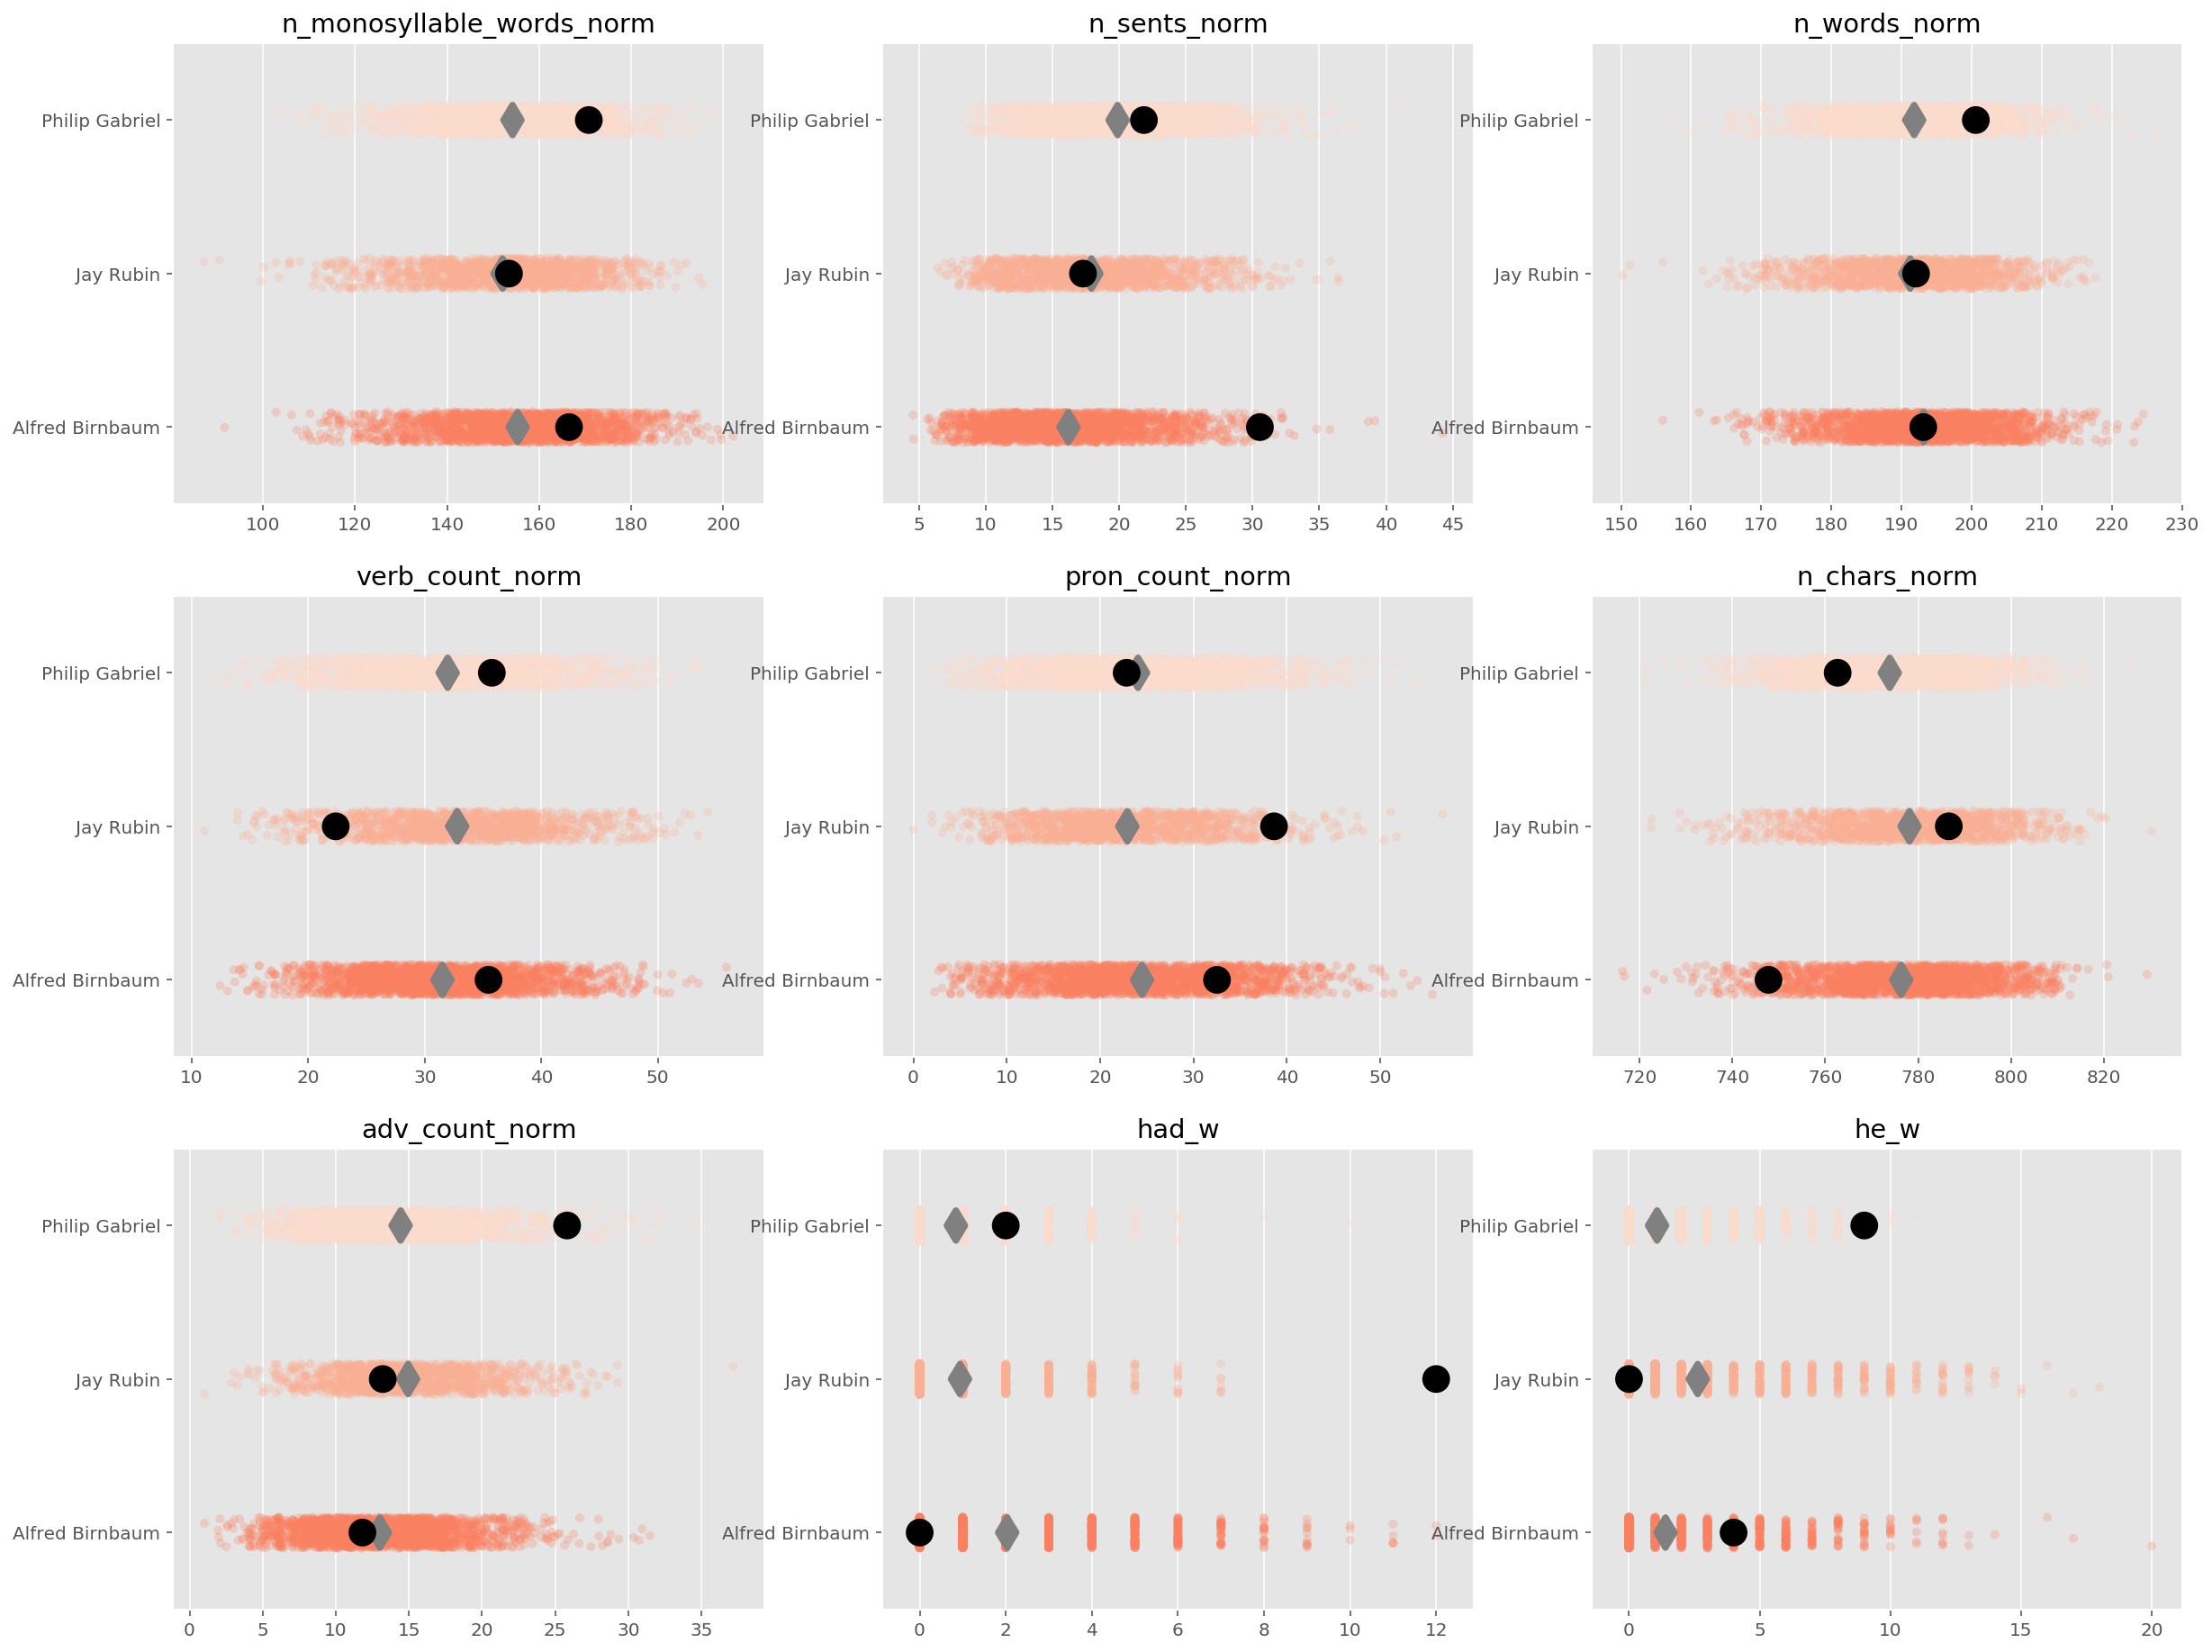

In [95]:
sns.set_palette("Reds")
preds2plot = ['n_monosyllable_words_norm',
              'n_sents_norm',
              'n_words_norm',
              'verb_count_norm',
              'pron_count_norm',
              'n_chars_norm',
              'adv_count_norm',
              'had_w',
              'he_w']
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16), sharex=False)

for i in range(len(preds2plot)):
    sns.stripplot(x=preds2plot[i], y='translator',
                  data=df, dodge=True, alpha=.25, zorder=1, ax=ax[int(i/3),i%3])
    # Show the conditional means
    sns.pointplot(x=preds2plot[i], y='translator',
                  data=df, dodge=.532, join=False, color='grey',
                  markers="d", scale=1.75, ci=None, ax=ax[int(i/3),i%3])

    # Show the individual values for most confident predictions
    sns.pointplot(x=preds2plot[i], y="translator",
                  data=top_predictions, dodge=.532, join=False, color='black',
                  markers="o", scale=1.75, ci=None, ax=ax[int(i/3),i%3])
    ax[int(i/3),i%3].set_title(preds2plot[i])
    ax[int(i/3),i%3].set_xlabel('')
    ax[int(i/3),i%3].set_ylabel('')

# plt.subplots_adjust(hspace=0.6)
plt.show()

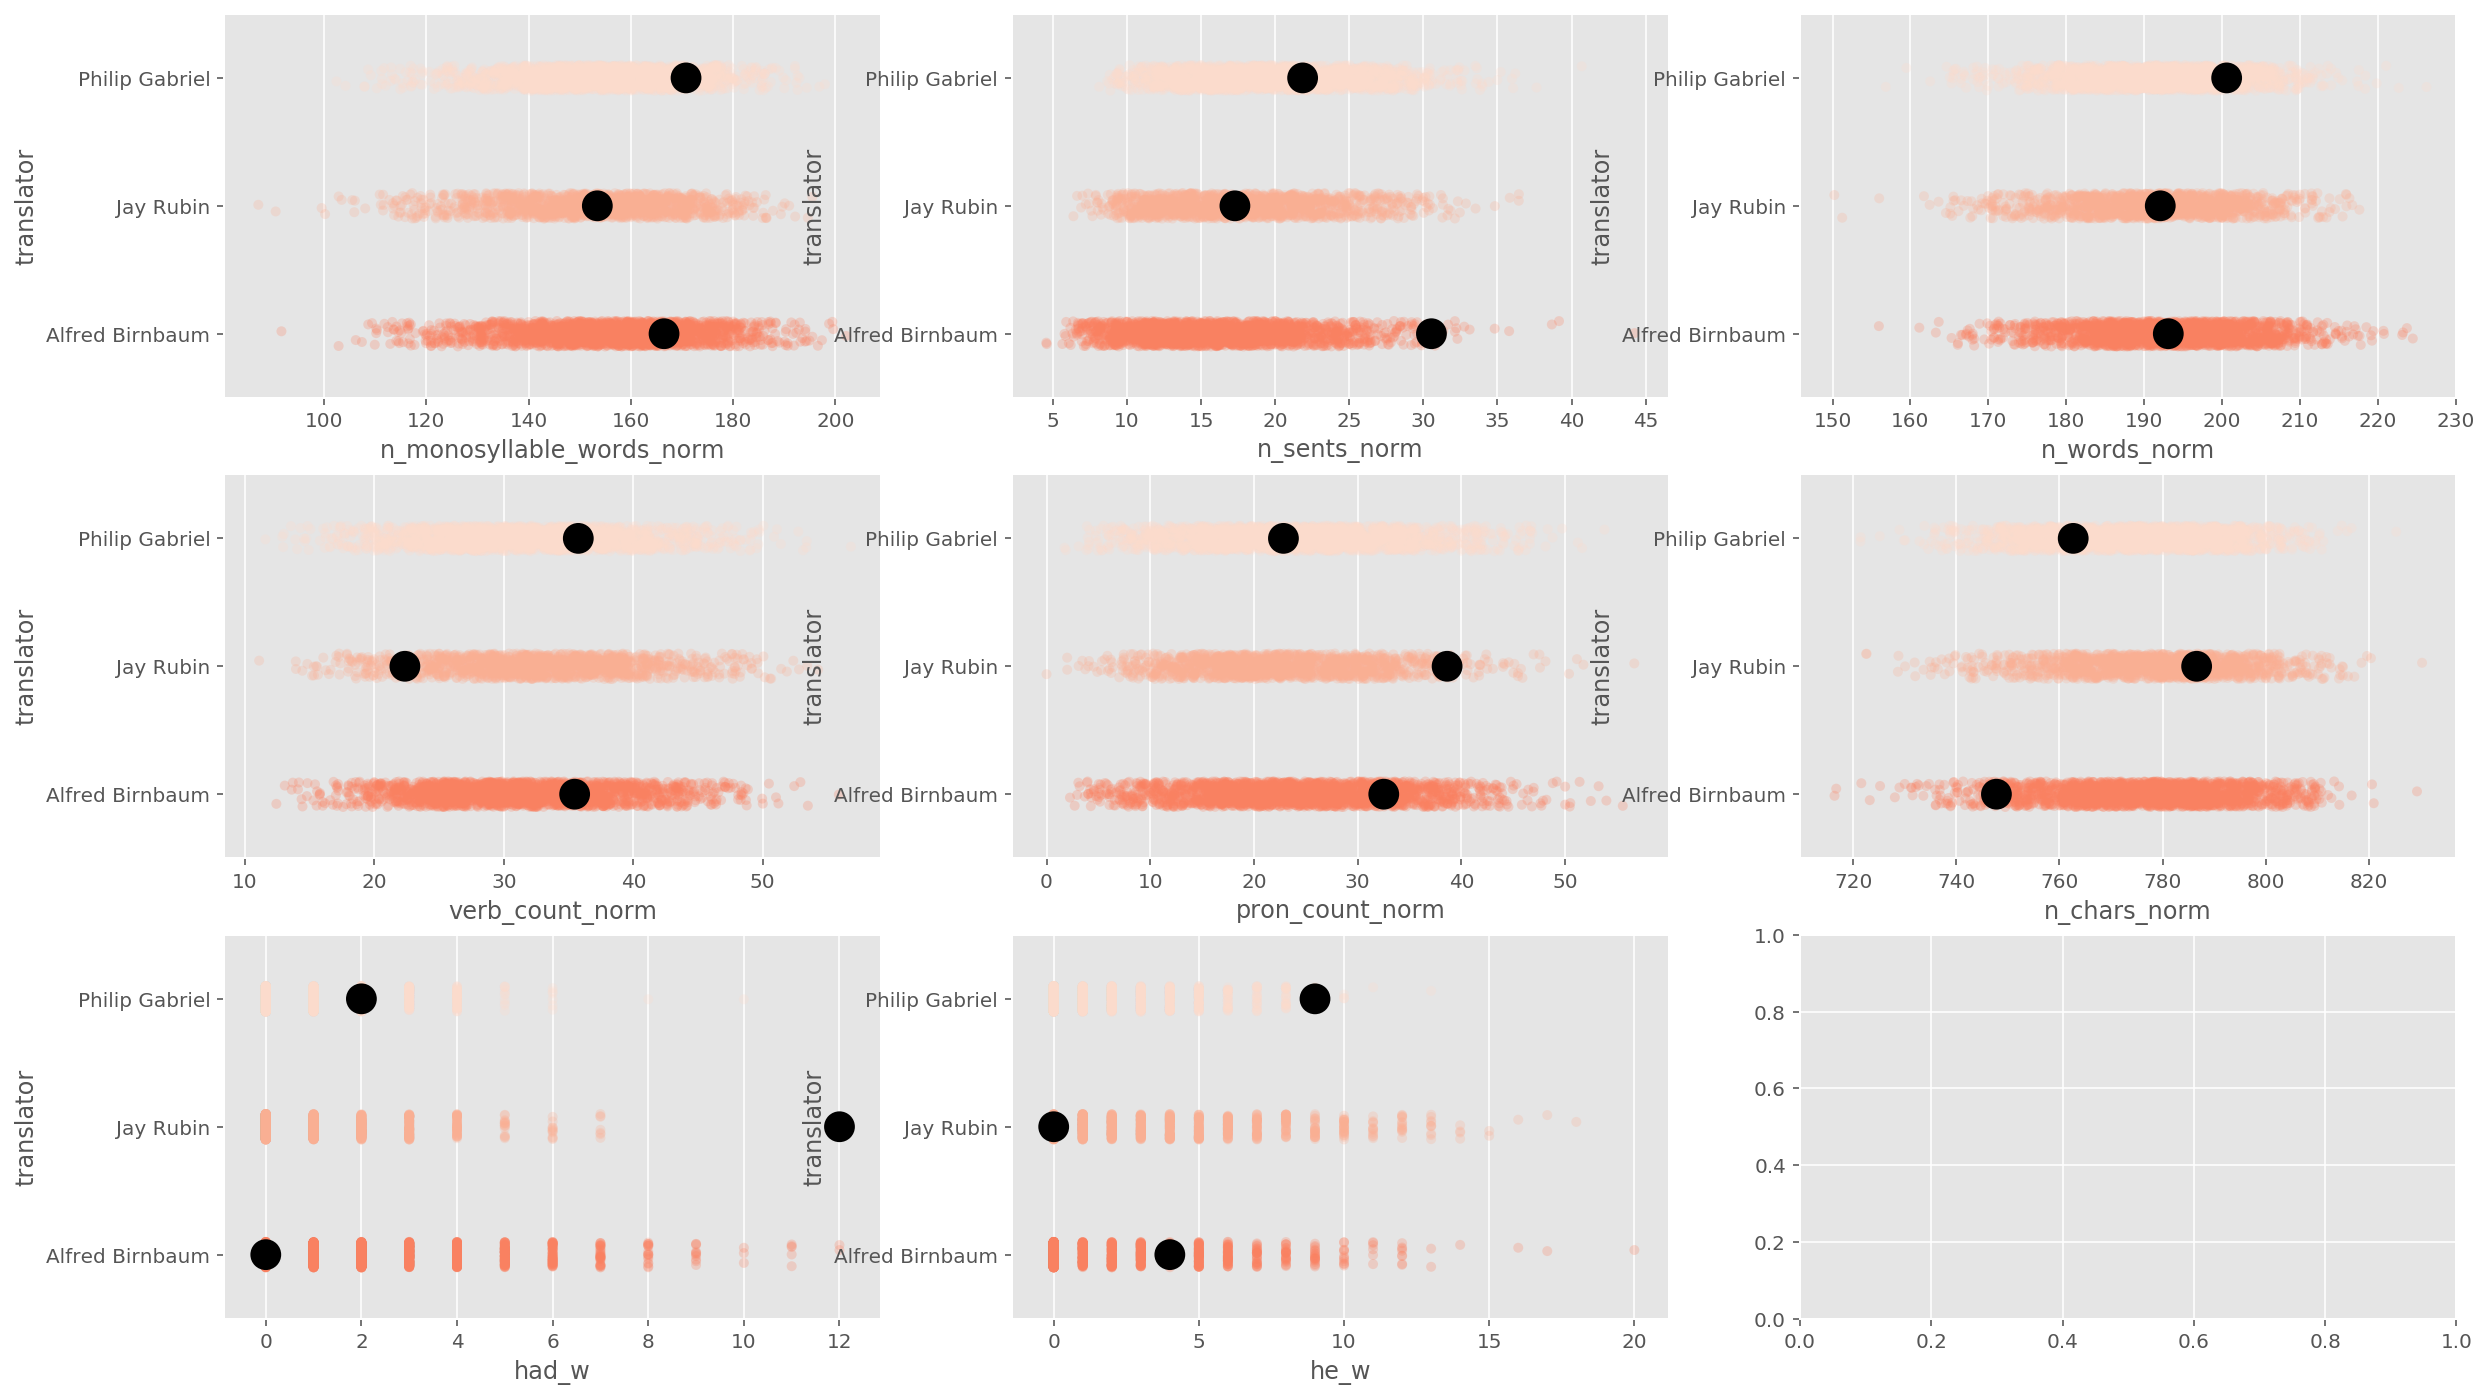

In [96]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 12), sharex=False)
# sns.despine(bottom=True, left=True)
# Show each observation with a scatterplot
sns.stripplot(x='n_monosyllable_words_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[0,0])
# Show the individual values for most confident predictions
sns.pointplot(x="n_monosyllable_words_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[0,0])

# Show each observation with a scatterplot
sns.stripplot(x='n_sents_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[0,1])
# Show the individual values for most confident predictions
sns.pointplot(x="n_sents_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[0,1])

# Show each observation with a scatterplot
sns.stripplot(x='n_words_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[0,2])
# Show the individual values for most confident predictions
sns.pointplot(x="n_words_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[0,2])

# Show each observation with a scatterplot
sns.stripplot(x='verb_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[1,0])
# Show the individual values for most confident predictions
sns.pointplot(x="verb_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[1,0])

# Show each observation with a scatterplot
sns.stripplot(x='pron_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[1,1])
# Show the individual values for most confident predictions
sns.pointplot(x="pron_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[1,1])

# Show each observation with a scatterplot
sns.stripplot(x='n_chars_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[1,2])
# Show the individual values for most confident predictions
sns.pointplot(x="n_chars_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[1,2])



# Show each observation with a scatterplot
sns.stripplot(x='had_w', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[2,0])
# Show the individual values for most confident predictions
sns.pointplot(x="had_w", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[2,0])

# Show each observation with a scatterplot
sns.stripplot(x='he_w', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1, ax=ax[2,1])
# Show the individual values for most confident predictions
sns.pointplot(x="he_w", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None, ax=ax[2,1])

plt.show()

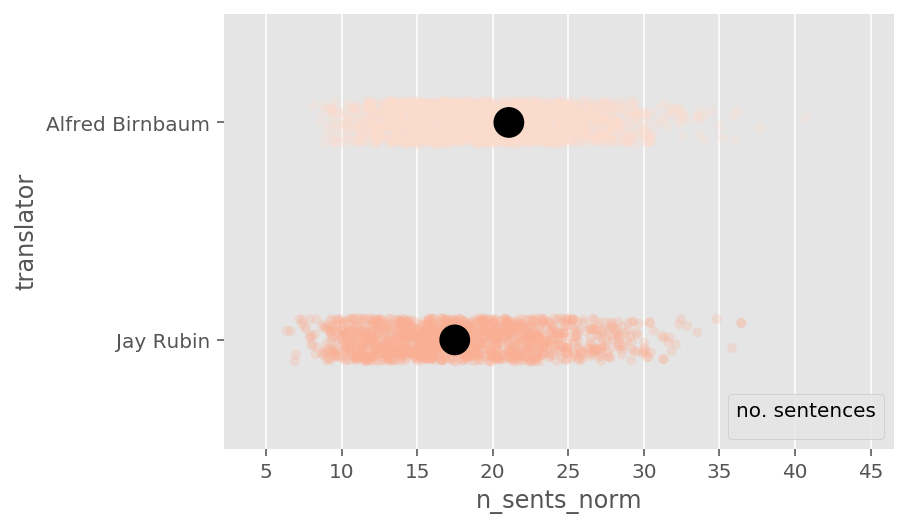

In [83]:
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x='n_sents_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the individual values for most confident predictions
sns.pointplot(x="n_sents_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, color='black',
              markers="o", scale=1.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="no. sentences",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

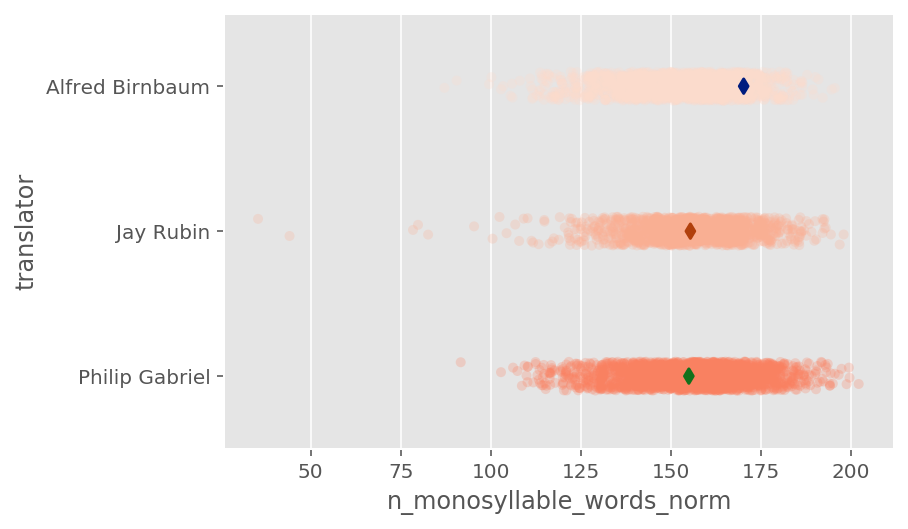

In [92]:
# Show each observation with a scatterplot
sns.stripplot(x='n_monosyllable_words_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(x="n_monosyllable_words_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

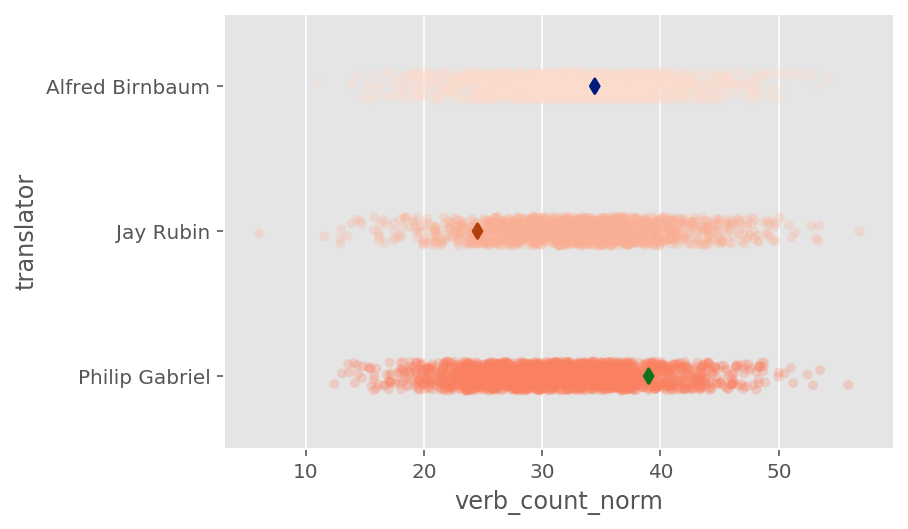

In [93]:
# Show each observation with a scatterplot
sns.stripplot(x='verb_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(x="verb_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

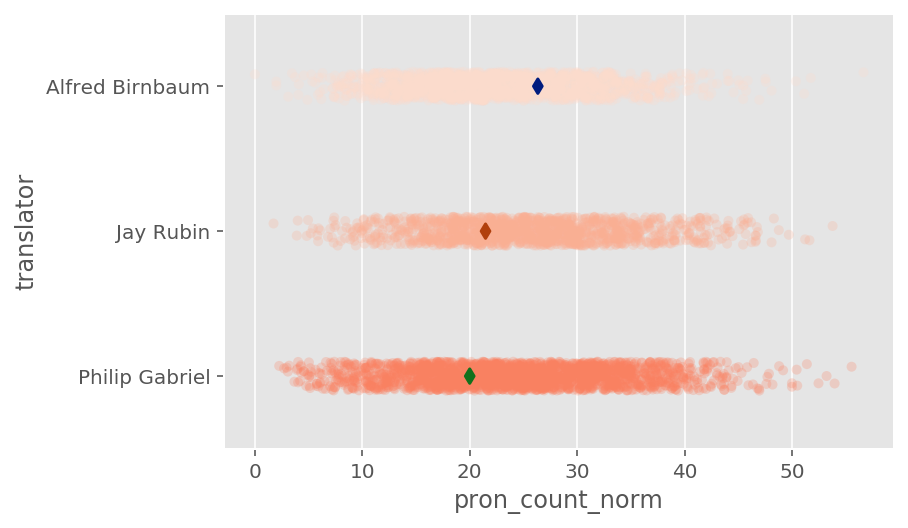

In [94]:
# Show each observation with a scatterplot
sns.stripplot(x='pron_count_norm', y='translator',
              data=df, dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(x="pron_count_norm", y="translator",
              data=top_predictions, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

In [95]:
test_text = Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

In [96]:
en_nlp = textacy.load_spacy_lang('en_core_web_sm')
test_parsed = en_nlp(test_text)

In [98]:
# Colourise - colours text in shell. Returns plain if colour doesn't exist.
def colourise(colour, text):
    if colour == "black":
        return "\033[1;30m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;31m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;32m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;33m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;34m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;35m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;36m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;37m" + str(text) + "\033[1;m"
    return str(text)

# Highlight - highlights text in shell. Returns plain if colour doesn't exist.
def highlight(colour, text):
    if colour == "black":
        return "\033[1;40m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;44m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;45m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;47m" + str(text) + "\033[1;m"
    return str(text)

# # Example usage:
# print(colourise("black", "Black"))
# print(colourise("red", "Red"))
# print(colourise("green", "Green"))
# print(colourise("yellow", "Yellow"))
# print(colourise("blue", "Blue"))
# print(colourise("magenta", "Magenta"))
# print(colourise("cyan", "Cyan"))
# print(colourise("gray", "Gray"))
# print(highlight("black", "Highlight: black"))
# print(highlight("red", "Highlight: red"))
# print(highlight("green", "Highlight: green"))
# print(highlight("yellow", "Highlight: yellow"))
# print(highlight("blue", "Highlight: blue"))
# print(highlight("magenta", "Highlight: magenta"))
# print(highlight("cyan", "Highlight: cyan"))
# print(highlight("gray", "Highlight: gray"))

# Example usage of colourise() + highlight()
# text = "Blue on red is difficult to read because the wavelengths are \
# refracted onto different areas of the eye."

# print(highlight("red", (colourise("blue", text))))


In [98]:
# print(highlight("red", 'No matter how out of focus the picture'))

In [99]:
# test_text.split()

In [99]:
top_predictions['chunks'].iloc[0]

' The young man had to drive his truck over to the warehouse to deliver his load of furniture, so he told Nakata to wait for him at a small park near the harbor. "Don’t move from here, okay?" Hoshino cautioned him. "There’s a restroom over there, and a water fountain. You got everything you need. If you wander off somewhere, you might not find your way back." "I understand. I’m not in Nakano Ward anymore." "Exactly. This isn’t Nakano. So sit tight, and I’ll be back real soon." "All right. I’ll stay right here." "Good. I’ll be back as soon as I finish my delivery." Nakata did as he was told, not moving from the bench, not even to use the restroom. He didn’t find staying put in one place for a long time very hard. Sitting still, in fact, was his specialty. He could see the sea from where he sat. This he hadn’t seen for a long, long time. When he was little, he and his family had gone to the seaside any number of times. He’d put on trunks, splash around on the shore, gather seashells at l

In [100]:
for i in range(len(top_predictions)):
    text = top_predictions['chunks'].iloc[i]
    parsed = top_predictions['parsed'].iloc[i]
    verbs = [str(token) for token in parsed if token.pos_ == 'VERB' ]
    pronouns = [str(token) for token in parsed if token.pos_ == 'PRON' ]
    fin_list = []
    verb_count = 0
    pronoun_count = 0
    stop_count = 0
    for word in text.split():
        if word in verbs:
            fin_list.append(colourise("red", word))
            verb_count += 1
        elif word in pronouns:
            fin_list.append(colourise("magenta", word))
            pronoun_count += 1
        elif word == 'had':
            fin_list.append(colourise("green", word))
        elif word == 'he':
            fin_list.append(highlight("yellow", word))
        elif '.' in word:
            fin_list.append(highlight("cyan", word[-1]))
            stop_count += 1
        else:
            fin_list.append(word)

    print('\n')
    print(top_predictions['translator'].iloc[i])
#     print(highlight("red",verb_count))
    print(colourise("red",'verbs'), verb_count, '   ', 
          colourise("magenta",'pronouns'), pronoun_count, '   ', 
          highlight("cyan",'stops'), stop_count,)
    print('\n')
    print(' '.join(fin_list))
    



Philip Gabriel
verbs 26     pronouns 15     stops 21


The young man had to drive his truck over to the warehouse to deliver his load of furniture, so he told Nakata to wait for him at a small park near the . "Don’t move from here, okay?" Hoshino cautioned . "There’s a restroom over there, and a water . You got everything you . If you wander off somewhere, you might not find your way " "I . I’m not in Nakano Ward " . This isn’t . So sit tight, and I’ll be back real " "All . I’ll stay right " . I’ll be back as soon as I finish my " Nakata did as he was told, not moving from the bench, not even to use the . He didn’t find staying put in one place for a long time very . Sitting still, in fact, was his . He could see the sea from where he . This he hadn’t seen for a long, long . When he was little, he and his family had gone to the seaside any number of . He’d put on trunks, splash around on the shore, gather seashells at low .


Jay Rubin
verbs 26     pronouns 34     stops 14


But ther

In [101]:
verbs = [str(token) for token in test_parsed if token.pos_ == 'VERB' ]
pronouns = [str(token) for token in test_parsed if token.pos_ == 'PRON' ]

NameError: name 'test_parsed' is not defined

In [102]:
fin_list = []
for word in test_text.split():
    if word in verbs:
        fin_list.append(highlight("red", word))
    elif word in pronouns:
        fin_list.append(highlight("green", word))
    elif word == 'had':
        fin_list.append(highlight("blue", word))
    elif word == 'he':
        fin_list.append(highlight("yellow", word))
    elif '.' in word:
        fin_list.append(highlight("cyan", word[-1]))
    else:
        fin_list.append(word)
        
print(' '.join(fin_list))


NameError: name 'test_text' is not defined

## Precision-Recall Plot

In [104]:
probabilities = lreg_final.predict_proba(X_test)

In [105]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

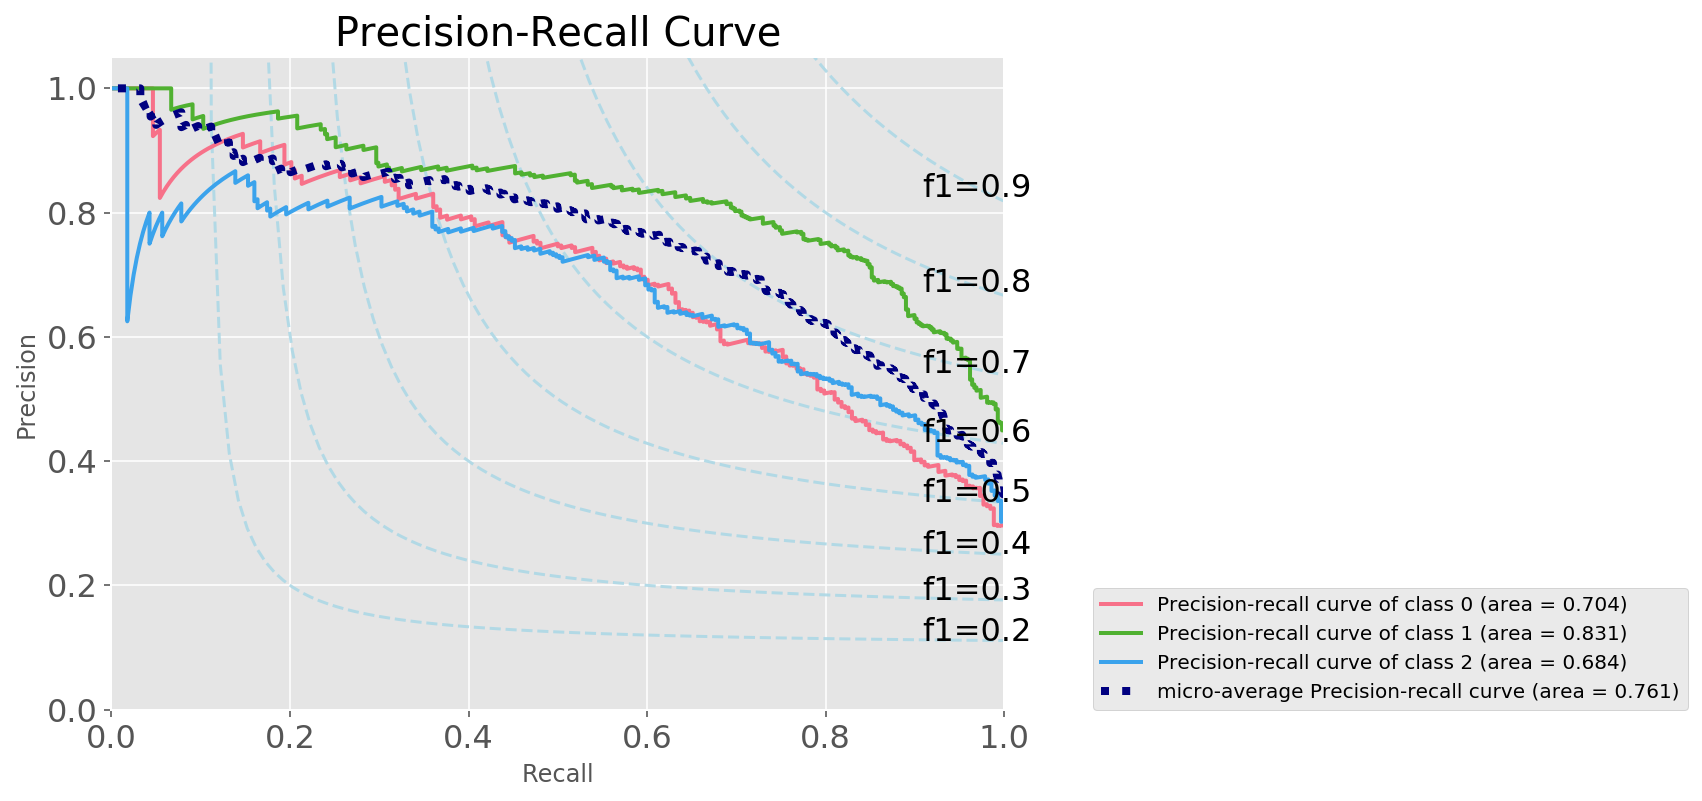

In [106]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [107]:
# label binarizer - not sure if needed?
y_bin = label_binarize(y_test, lreg_final.classes_)

In [108]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(average_precision_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),4))

Area under precision-recall curve:
Class 0: 0.7041
Class 1: 0.8309
Class 2: 0.6841


## ROC Plot

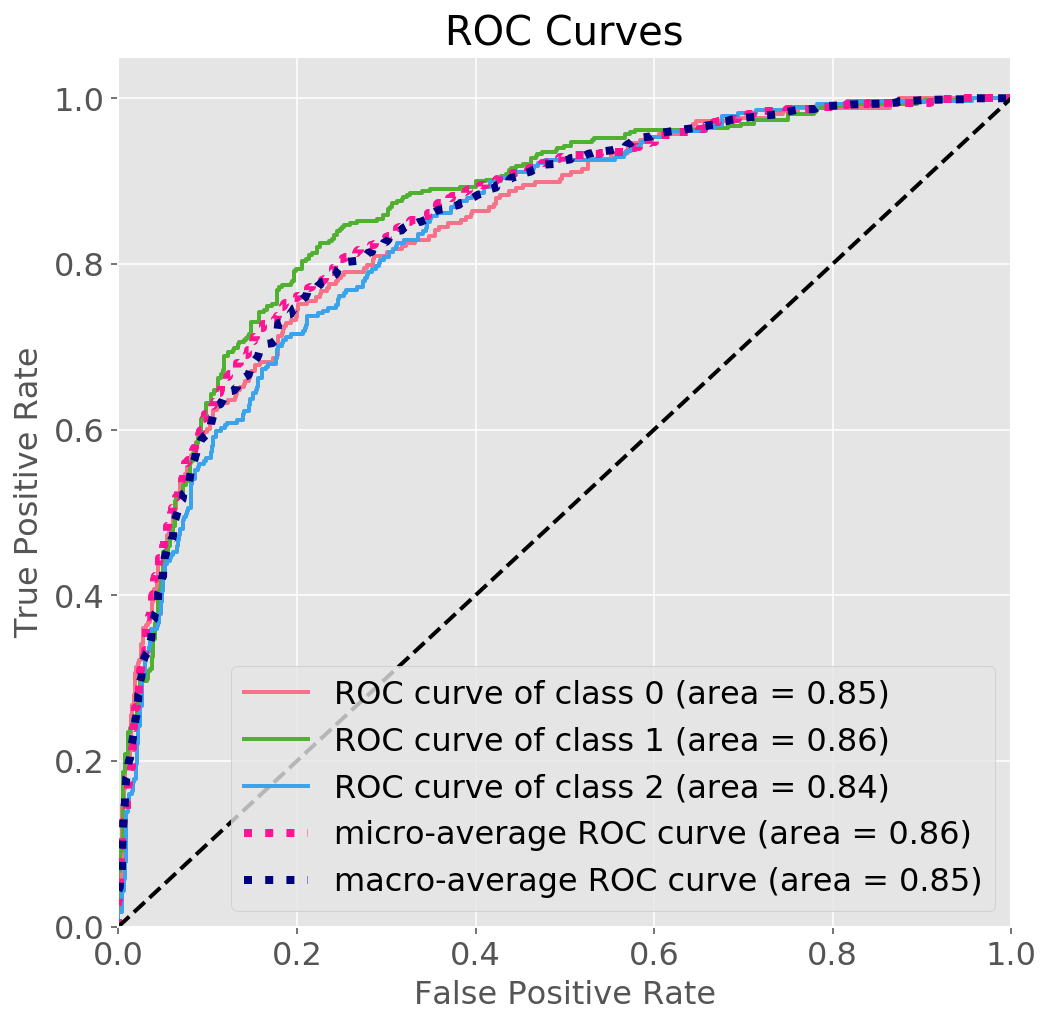

In [109]:
skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,8), cmap=cmap)
plt.show()

In [110]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),2))

Area under ROC curve (ROC-AUC):
Class 0: 0.85
Class 1: 0.86
Class 2: 0.84


In [111]:
skplt.metrics.roc_curve(y_test==0, probabilities[:,0])

(array([0.        , 0.        , 0.        , 0.00143062, 0.00143062,
        0.00429185, 0.00429185, 0.00572246, 0.00572246, 0.00715308,
        0.00715308, 0.01001431, 0.01001431, 0.01144492, 0.01144492,
        0.01287554, 0.01287554, 0.01430615, 0.01430615, 0.01573677,
        0.01573677, 0.01716738, 0.01716738, 0.018598  , 0.018598  ,
        0.02002861, 0.02002861, 0.02145923, 0.02145923, 0.02288984,
        0.02288984, 0.02575107, 0.02575107, 0.02718169, 0.02718169,
        0.03147353, 0.03147353, 0.03290415, 0.03290415, 0.03576538,
        0.03576538, 0.03719599, 0.03719599, 0.03862661, 0.03862661,
        0.04005722, 0.04005722, 0.04291845, 0.04291845, 0.04434907,
        0.04434907, 0.05007153, 0.05007153, 0.05150215, 0.05150215,
        0.05436338, 0.05436338, 0.05722461, 0.05722461, 0.05865522,
        0.05865522, 0.06151645, 0.06151645, 0.06294707, 0.06294707,
        0.06437768, 0.06437768, 0.0658083 , 0.0658083 , 0.06866953,
        0.06866953, 0.07153076, 0.07153076, 0.07